In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
        
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
plotly=4.6.0 already installed
chart-studio=1.1.0 already installed
plotly-orca=1.3.1 already installed
Running command `conda install --yes unicodedata2`... ok
Solving environment: ...working... done

# All requested packages already installed.


Importando librerías ...
Las librerías has sido importadas con éxito


In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

import re
import unicodedata

%matplotlib inline

# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

In [3]:
def scatter(y_test, y_pred, y):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Medido')
    ax.set_ylabel('Predicho')
    plt.show()

In [4]:
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import numpy as np
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')


In [5]:
# LECTURA DEL ARCHIVO DE DATOS
data_clean = pd.read_csv("CleanCSV/Clean08_OultiersxZona.csv")
#data_clean =  pd.read_csv('CleanCSV/Clean08_OultiersxZona_Ale_02.csv')

In [6]:
# SÓLO PARA USO EN COMPARACIONES
data_clean_ORIGINAL = data_clean.copy(deep=True) 

In [7]:
data_clean.head(3)

Unnamed: 0  Unnamed: 0.1       País        Provincia             Área  Localidad       Zona      Lugar operation property_type  ...  gimnasio  subte  baulera  piscina_house  piscina_depart  desc_banios  tipo_propiedad_PH  tipo_propiedad_apartment  tipo_propiedad_house  tipo_propiedad_store
0           0             0  Argentina  Capital Federal  Capital Federal  Mataderos  Mataderos  Mataderos      sell            PH  ...       0.0    0.0      0.0              0               0          1.0                  1                         0                     0                     0
1           1             1  Argentina     Buenos Aires         Zona Sur   La Plata   La Plata   La Plata      sell     apartment  ...       0.0    0.0      0.0              0               0          1.0                  0                         1                     0                     0
2           2             2  Argentina  Capital Federal  Capital Federal  Mataderos  Mataderos  Mataderos      sell     apartment  ...       0.0    0.0      0.0              0               0          1.0                  0                         1                     0                     0

[3 rows x 44 columns]

In [8]:
display(data_clean.shape)
data_clean.columns

(118570, 44)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store'], dtype='object')

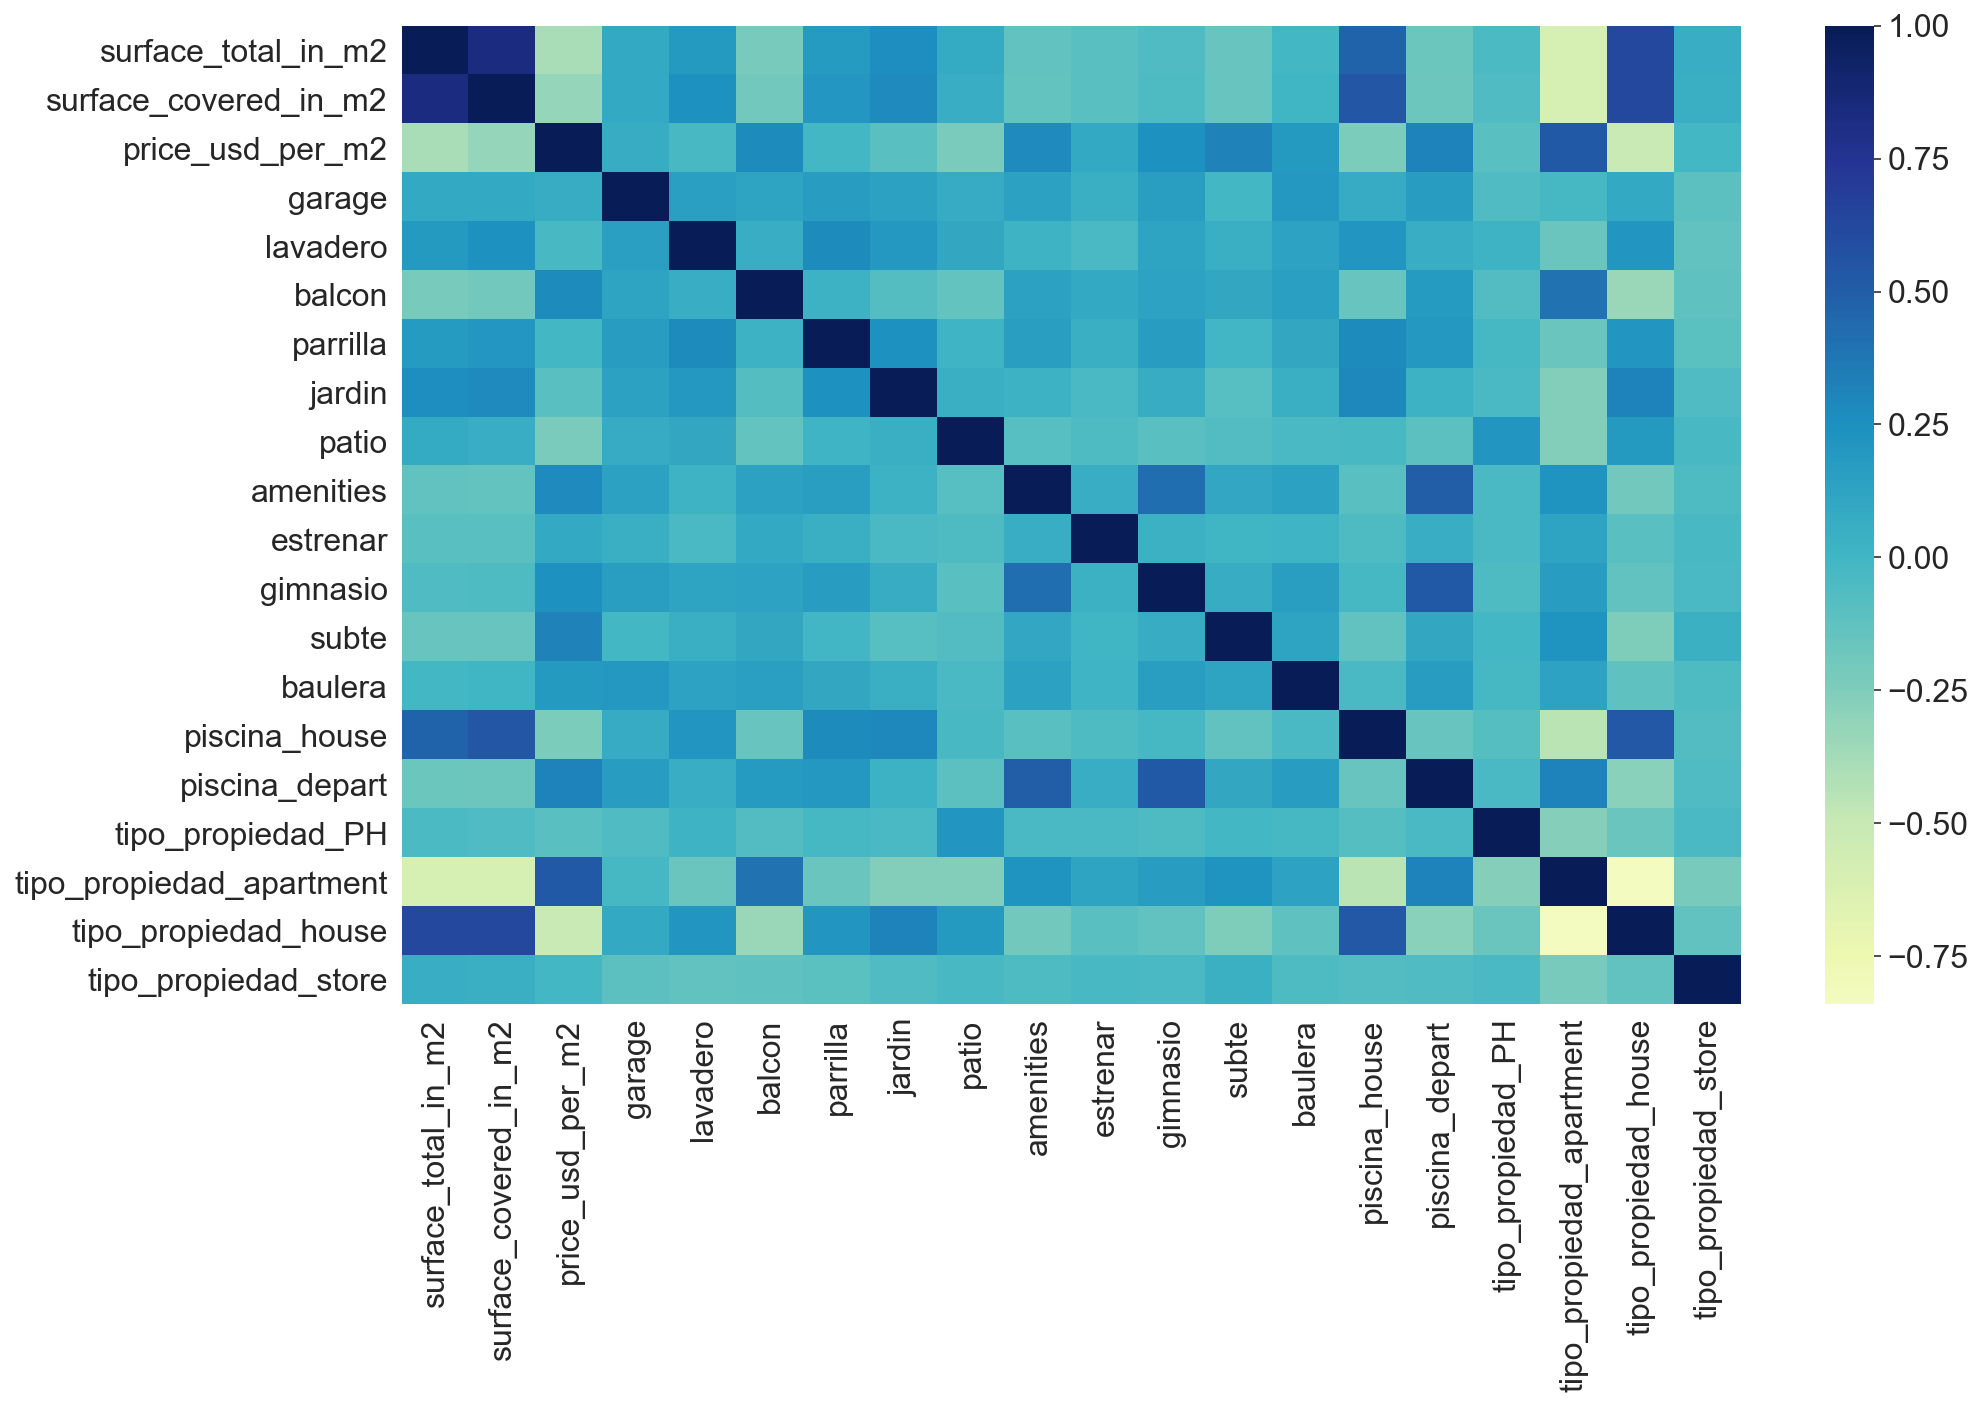

In [9]:
dfCompleto = data_clean.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
                                                                          'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
                                                                          'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
                                                                          'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
                                                                          'tipo_propiedad_apartment', 'tipo_propiedad_house',
                                                                          'tipo_propiedad_store', "Lugar"]]
sns.heatmap(dfCompleto.corr(), center=0, cmap="YlGnBu", annot=False);

### 0) Primer aproximación al Modelo con lo datos disponibles sólo en Capital

#### Hacemos esto para comparar los R2 que obtendremos más adelante utilizando otros features que harán que el dataset disponible varíe

In [10]:
Xo_yo = data_clean.loc[(data_clean["Área"] == "Capital Federal")].loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
                                                                          'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
                                                                          'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
                                                                          'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
                                                                          'tipo_propiedad_apartment', 'tipo_propiedad_house',
                                                                          'tipo_propiedad_store', "Lugar"]]
Xo_yo.isnull().sum()

surface_total_in_m2         1336
surface_covered_in_m2       2646
price_usd_per_m2            6071
garage                         0
lavadero                       0
balcon                         0
parrilla                       0
jardin                         0
patio                          0
amenities                      0
estrenar                       0
gimnasio                       0
subte                          0
baulera                        0
piscina_house                  0
piscina_depart                 0
tipo_propiedad_PH              0
tipo_propiedad_apartment       0
tipo_propiedad_house           0
tipo_propiedad_store           0
Lugar                          0
dtype: int64

In [11]:
# Eliminamos con nulos
Xo_yo.dropna(how="any", axis=0, inplace= True)
Xo_yo.shape

(23971, 21)

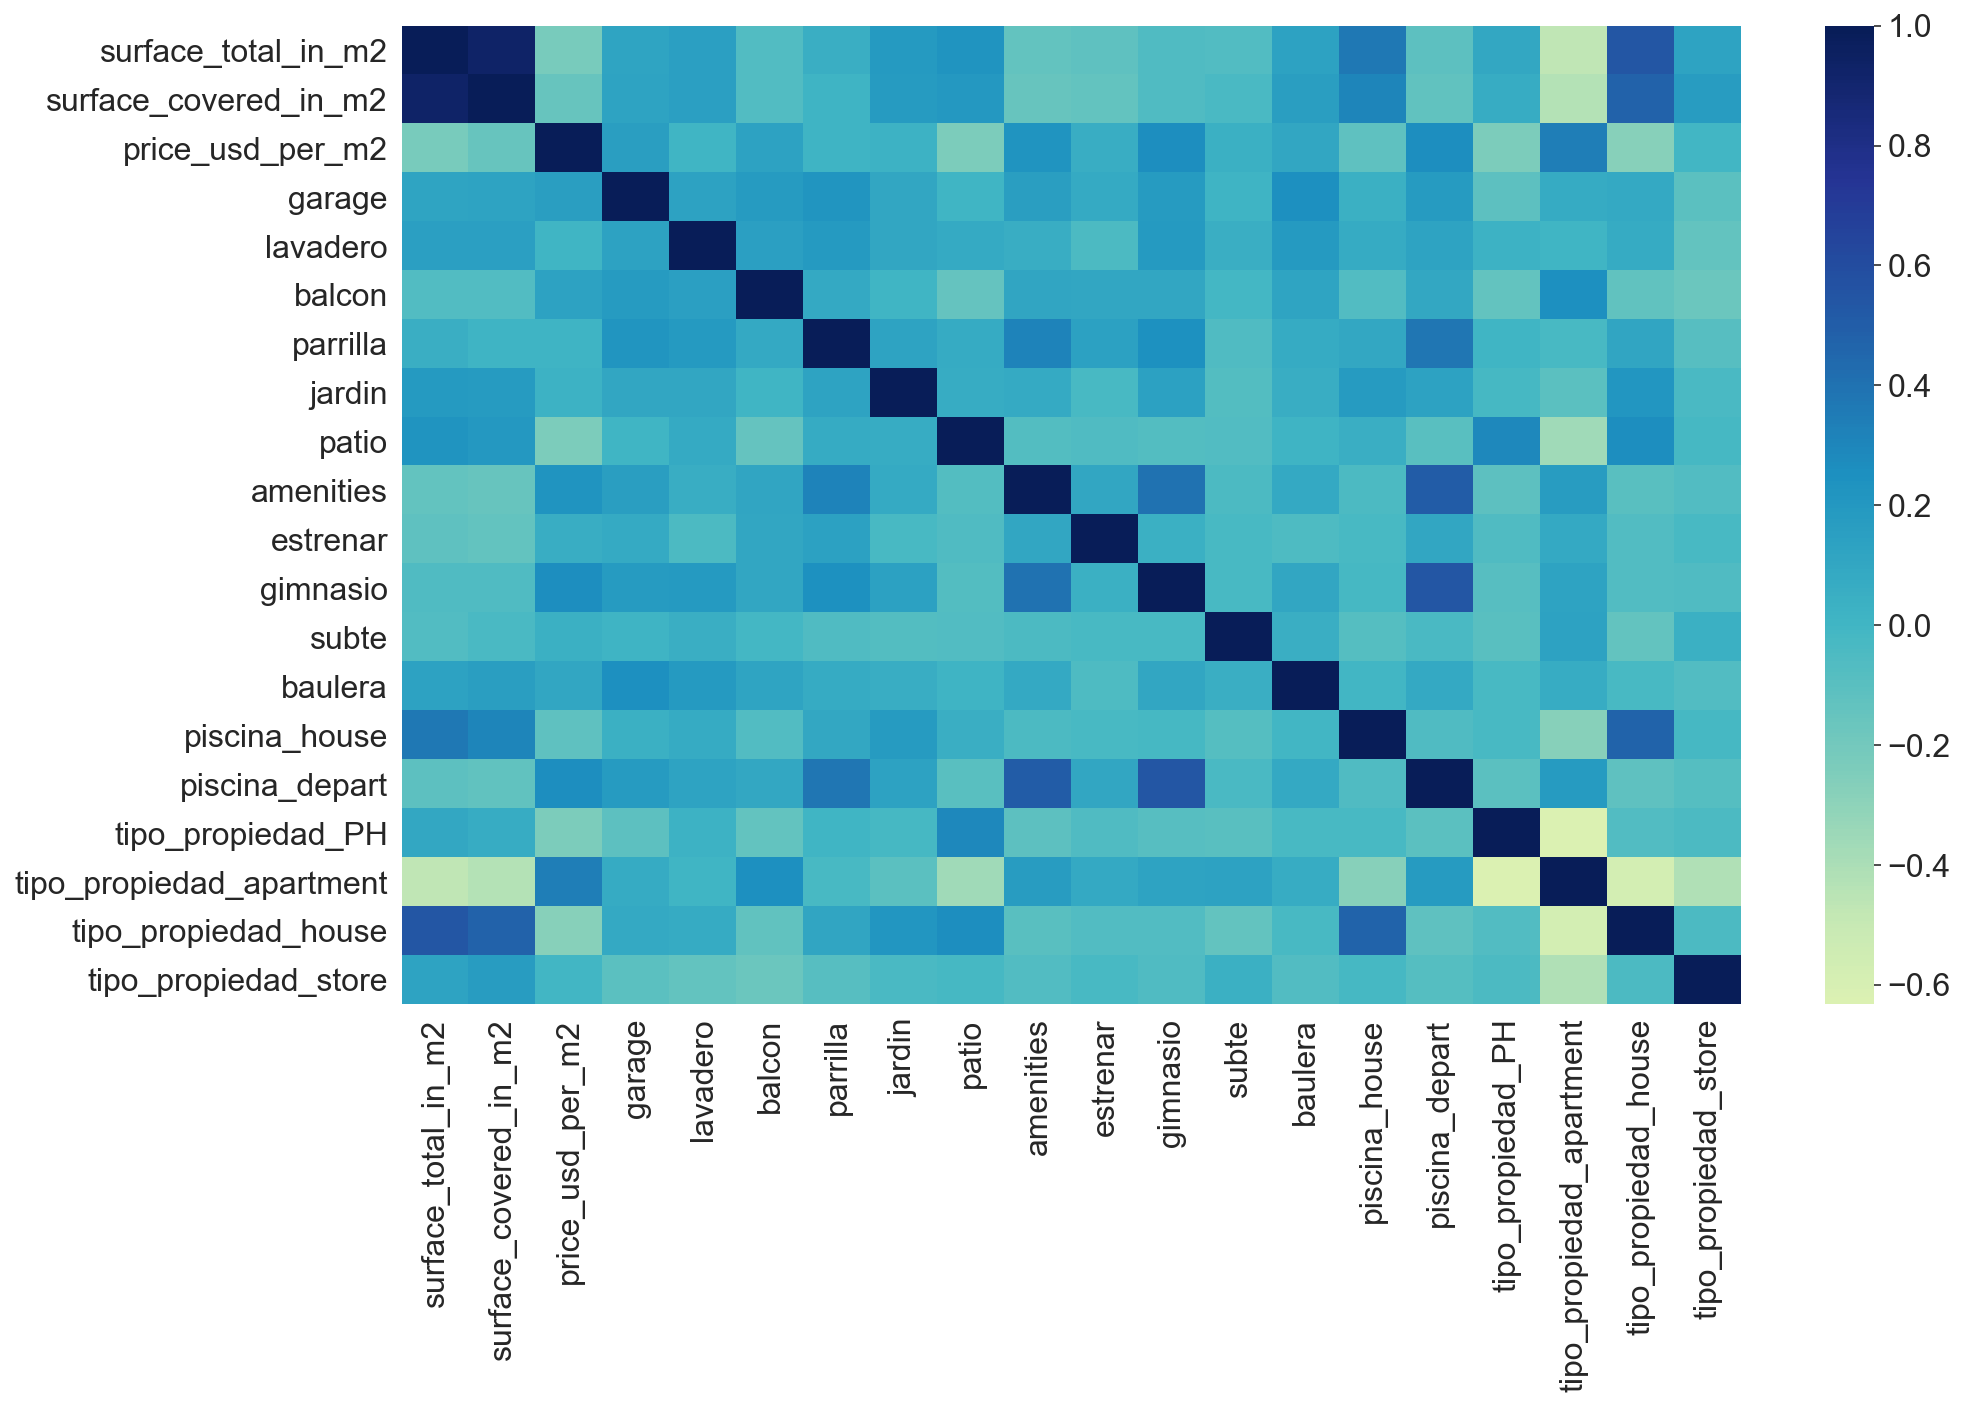

In [12]:
sns.heatmap(Xo_yo.corr(), center=0, cmap="YlGnBu", annot=False);

In [13]:
Xo = Xo_yo[['surface_total_in_m2', 'surface_covered_in_m2',  
            'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
            'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
            'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
            'tipo_propiedad_apartment', 'tipo_propiedad_house',
            'tipo_propiedad_store', "Lugar"]]
Xo.shape

(23971, 20)

#### 0-a) Armamos las Dummies de "Lugar" (Para el caso de Capital federal, son los barrios/sub-barrios):

In [14]:
dummies_lugar = pd.get_dummies(Xo['Lugar'], prefix="dumm", drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lugar.shape

(23971, 61)

In [15]:
Xo = pd.concat([Xo, dummies_lugar],axis=1)
Xo.drop(['Lugar'], axis=1, inplace=True)

In [16]:
Xo.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'dumm_Agronomía', 'dumm_Almagro', 'dumm_Balvanera', 'dumm_Barracas', 'dumm_Barrio Norte', 'dumm_Belgrano', 'dumm_Boca', 'dumm_Boedo', 'dumm_Caballito', 'dumm_Capital Federal', 'dumm_Catalinas', 'dumm_Centro / Microcentro', 'dumm_Chacarita', 'dumm_Coghlan', 'dumm_Colegiales', 'dumm_Congreso', 'dumm_Constitución', 'dumm_Flores', 'dumm_Floresta', 'dumm_Las Cañitas', 'dumm_Liniers', 'dumm_Mataderos', 'dumm_Monserrat', 'dumm_Monte Castro', 'dumm_Nuñez', 'dumm_Once', 'dumm_Palermo', 'dumm_Palermo Chico', 'dumm_Palermo Hollywood', 'dumm_Palermo Soho', 'dumm_Palermo Viejo', 'dumm_Parque Avellaneda', 'dumm_Parque Centenario', 'dumm_Parque Chacabuco', 'dumm_Parque Chas', 'dumm_Parque Patricios'

In [17]:
yo = Xo_yo[['price_usd_per_m2']]
yo.shape

(23971, 1)

In [18]:
print("Shape X:", Xo.shape)
print("Type X:", type(Xo))
print("Shape y:", yo.shape)
print("Type y:", type(yo))

Shape X: (23971, 80)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (23971, 1)
Type y: <class 'pandas.core.frame.DataFrame'>


#### 0-b) Usando STATS MODEL - Armamos "Xo_const":

In [19]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [20]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
Xo_const = sm.add_constant(Xo)
Xo_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  garage  lavadero  balcon  parrilla  jardin  patio  amenities  ...  dumm_Villa Lugano  dumm_Villa Luro  dumm_Villa Ortuzar  dumm_Villa Pueyrredón  dumm_Villa Real  dumm_Villa Riachuelo  dumm_Villa Santa Rita  dumm_Villa Soldati  dumm_Villa Urquiza  dumm_Villa del Parque
0    1.0                 55.0                   40.0     0.0       1.0     0.0       0.0     0.0    1.0        0.0  ...                  0                0                   0                      0                0                     0                      0                   0                   0                      0
2    1.0                 55.0                   55.0     0.0       1.0     0.0       0.0     0.0    0.0        0.0  ...                  0                0                   0                      0                0                     0                      0                   0                   0                      0
7    1.0                 45.0                   40.0     0.0       1.0     0.0       0.0     0.0    0.0        0.0  ...                  0                0                   0                      0                0                     0                      0                   0                   0                      0

[3 rows x 81 columns]

#### 0-c) Usando STATS MODEL - con "Xo_const":

In [21]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(Xo_const, yo)

In [22]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 245390.62622833994
EMC train: 245694.47814894046
R2:  0.5735510456164273
R2: train: 0.5735510456164273
R2: TEST: 0.5785566960396912


In [23]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     300.9
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:49:19   Log-Likelihood:            -1.3707e+05
No. Observations:               17978   AIC:                         2.743e+05
Df Residuals:                   17897   BIC:                         2.749e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

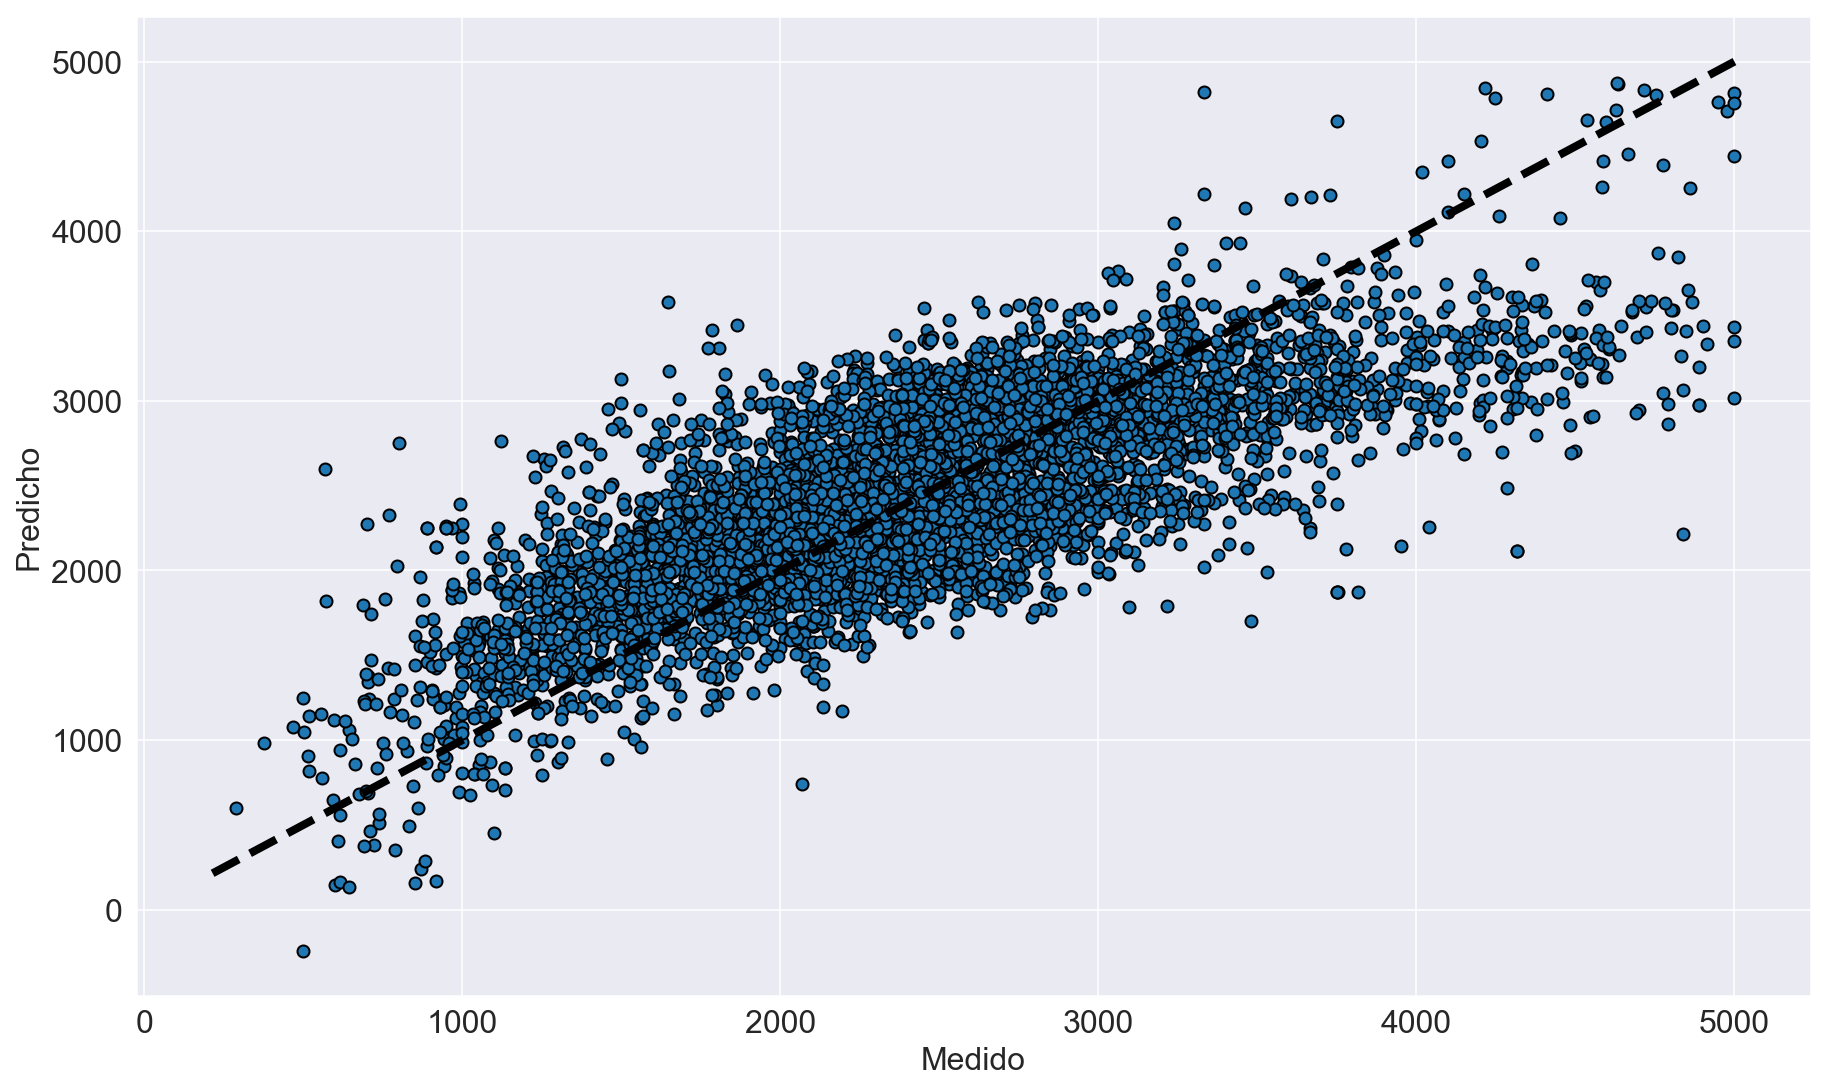

In [24]:
scatter(y_test, predictions2, yo)

##### Se observa que para los Datos de Capital Federal, incluyendo Dummies por Barrio obtenermos, R2 Train/Test de 0,58 / 0,55.


### AHORA VAMOS A VOLVER A TODO EL DATASET DISPONIBLE PARA TODA LA ARGENTINA:

<hr id="Ubicaciones">

### 1) Imputamos valores adicionales en la columna "ROOMS"

In [25]:
print(data_clean.rooms.isnull().sum())

64741


In [26]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\sambientes", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambientes", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

64741
53585


In [27]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\samb", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" amb", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

53585
50429


In [28]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("1\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambiente", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
50429


In [29]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("un\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("un ambiente", "1").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
49892


In [30]:
data_clean = data_clean.drop(columns=["description"])

### 2) BINARIZACIÓN DE LAT-LOT (ARMADO DE PARCELAS)

In [31]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

50412


50412

In [32]:
# Eliminamos filas sin LAT o LOT
data_clean.dropna(subset=['lat', 'lon'], how="any", axis=0, inplace= True)

In [33]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

0


0

In [34]:
data_clean.shape

(68158, 43)

In [35]:
# Vemos cómo nos queda distribuídas geográficamente las muestras luego del Drop anterior
data_clean.Área.value_counts()[0:40]

Capital Federal        23204
Zona Norte             11197
Costa Atlántica         8029
Zona Sur                5849
Zona Oeste              5515
Santa Fe                5232
Córdoba                 5044
Interior                1513
Neuquén                  470
Río Negro                432
Misiones                 363
Mendoza                  333
Entre Ríos               258
Salta                    207
Tucumán                  128
San Luis                 126
La Pampa                  64
Chubut                    52
Chaco                     40
San Juan                  23
Jujuy                     22
Tierra Del Fuego          22
Santa Cruz                17
Corrientes                10
La Rioja                   4
Catamarca                  3
Santiago Del Estero        1
Name: Área, dtype: int64

In [36]:
# Con 4000 BINS en LAT se obtienen una resolución de 0.015 grados por BIN (unas 14 cuadras)
lat_bins= pd.cut(data_clean.lat, 4000, right=False)
display(lat_bins)
lat_categories = pd.cut(data_clean.lat, 4000, right=False, labels=False) # labels=False implica que me devuelve el bin al que pertenece
lat_categories

0         [-34.668, -34.653)
1         [-34.905, -34.891)
2         [-34.653, -34.638)
3         [-34.653, -34.638)
4         [-38.007, -37.993)
                 ...        
118503    [-34.609, -34.594)
118508    [-34.594, -34.579)
118510    [-34.564, -34.549)
118559    [-34.564, -34.549)
118567    [-34.579, -34.564)
Name: lat, Length: 68158, dtype: category
Categories (4000, interval[float64]): [[-54.824, -54.809) < [-54.809, -54.794) < [-54.794, -54.779) < [-54.779, -54.765) ... [4.486, 4.501) < [4.501, 4.516) < [4.516, 4.531) < [4.531, 4.605)]

0         1358
1         1342
2         1359
3         1359
4         1133
          ... 
118503    1362
118508    1363
118510    1365
118559    1365
118567    1364
Name: lat, Length: 68158, dtype: int64

In [37]:
lat_categories = lat_categories.astype("str", copy=True)
type(lat_categories[0])

str

In [38]:
# Con 2000 BINS en LON se obtienen una resolución de 0.011 grados por BIN (unas 8 cuadras)
lon_bins= pd.cut(data_clean.lon, 2000, right=False)
display(lon_bins)
lon_categories = pd.cut(data_clean.lon, 2000, right=False, labels=False) # labels=False impluca que me devuelve el bin al que pertenece
lon_categories.value_counts()

0         [-58.517, -58.506)
1         [-57.969, -57.958)
2         [-58.528, -58.517)
3         [-58.517, -58.506)
4         [-57.552, -57.541)
                 ...        
118503    [-58.408, -58.397)
118508    [-58.408, -58.397)
118510    [-58.452, -58.441)
118559    [-58.452, -58.441)
118567    [-58.485, -58.474)
Name: lon, Length: 68158, dtype: category
Categories (2000, interval[float64]): [[-75.679, -75.668) < [-75.668, -75.657) < [-75.657, -75.646) < [-75.646, -75.635) ... [-53.777, -53.766) < [-53.766, -53.755) < [-53.755, -53.744) < [-53.744, -53.711)]

1652    3379
1574    2742
1571    2621
1570    2138
1568    2123
        ... 
726        1
917        1
1492       1
1428       1
0          1
Name: lon, Length: 753, dtype: int64

In [39]:
lon_categories = lon_categories.astype("str", copy=True)
type(lon_categories[0])

str

In [40]:
lat_lon = lat_categories + "/" + lon_categories
lat_lon.value_counts()

1133/1652    2024
1363/1574     769
1132/1652     618
1364/1571     617
1365/1569     605
             ... 
1362/665        1
1339/1606       1
1077/693        1
1377/1555       1
1063/741        1
Length: 3988, dtype: int64

In [41]:
lat_lon.shape

(68158,)

In [42]:
data_clean = pd.concat([data_clean, lat_lon], axis=1)

In [43]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 0], dtype='object')

In [44]:
# Renombramos la columna que recién creamos (por defecto la llamó 0)
data_clean.rename(columns={0: "lat_lon"}, inplace=True)

### 3) Eliminamos algunas columnas que ya no utilizaremos

In [45]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

In [46]:
data_clean.drop(['Unnamed: 0', 'Unnamed: 0.1', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 
                 'floor', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 
                 'desc_banios'], axis=1, inplace=True)

In [47]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

### 4) Generamos DUMMIES para los pares de LAT-LON que generamos antes

In [48]:
dummies_lat_lon = pd.get_dummies(data_clean['lat_lon'], drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lat_lon.shape

(68158, 3987)

In [49]:
data_clean = pd.concat([data_clean, dummies_lat_lon],axis=1)

In [50]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       ...
       '989/400', '989/401', '990/397', '990/400', '990/404', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=4016)

### 4) "dataf" es una dataframe intermedio donde verificamos que ya no tengamos nulos en las columnas de interés

In [51]:
data_clean.isnull().sum()[0:20]

País                         0
Provincia                    0
Área                         0
Localidad                    0
Zona                         0
Lugar                        0
price_aprox_usd          10998
surface_total_in_m2      11165
surface_covered_in_m2    12841
price_usd_per_m2         19058
rooms                    16987
garage                       0
lavadero                     0
balcon                       0
parrilla                     0
jardin                       0
patio                        0
amenities                    0
estrenar                     0
gimnasio                     0
dtype: int64

In [52]:
dataf = data_clean.dropna(how="any", axis=0)

In [53]:
dataf.isnull().sum().sum()

0

In [54]:
dataf.shape

(35739, 4016)

In [55]:
# Vemos nuevamente cómo nos quedan los datos disponibles distribuídos geográficamente
dataf.Área.value_counts()[0:40]

Capital Federal        16317
Zona Norte              5832
Costa Atlántica         4740
Zona Sur                2398
Zona Oeste              2280
Santa Fe                1657
Córdoba                 1531
Interior                 476
Neuquén                  150
Río Negro                128
Misiones                  78
Mendoza                   58
Salta                     19
Tierra Del Fuego          13
Entre Ríos                12
Tucumán                   11
Chaco                     10
San Luis                   8
Chubut                     8
Santa Cruz                 6
Corrientes                 2
Jujuy                      2
La Rioja                   2
Santiago Del Estero        1
Name: Área, dtype: int64

In [56]:
dataf.columns[0:30]

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon', '0/669'], dtype='object')

### 5) Armamos X e y

In [57]:
X = dataf.drop(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_usd_per_m2', 'lat_lon', 'price_aprox_usd'], axis=1)

In [58]:
X.shape

(35739, 4007)

In [59]:
y = dataf['price_usd_per_m2']

In [60]:
y.shape

(35739,)

In [61]:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (35739, 4007)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (35739,)
Type y: <class 'pandas.core.series.Series'>


<hr id="Ubicaciones">

### 6) Pimera aproximación con STATS MODEL - OLS

In [62]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [63]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
X_const = sm.add_constant(X)
X_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  rooms  garage  lavadero  balcon  parrilla  jardin  patio  ...  989/400  989/401  990/397  990/400  990/404  990/408  991/410  993/398  994/397  994/419
0    1.0                 55.0                   40.0    2.0     0.0       1.0     0.0       0.0     0.0    1.0  ...        0        0        0        0        0        0        0        0        0        0
2    1.0                 55.0                   55.0    2.0     0.0       1.0     0.0       0.0     0.0    0.0  ...        0        0        0        0        0        0        0        0        0        0
7    1.0                 45.0                   40.0    1.0     0.0       1.0     0.0       0.0     0.0    0.0  ...        0        0        0        0        0        0        0        0        0        0

[3 rows x 4008 columns]

#### 6-a) Usando "X_const":

In [64]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_const, y)

In [65]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 176951.60387621762
EMC train: 201552.52775547304
R2:  0.745002226197458
R2: train: 0.745002226197458
R2: TEST: 0.7174438358055251


In [66]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     36.31
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:51:29   Log-Likelihood:            -1.9998e+05
No. Observations:               26804   AIC:                         4.040e+05
Df Residuals:                   24807   BIC:                         4.203e+05
Df Model:                        1996                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

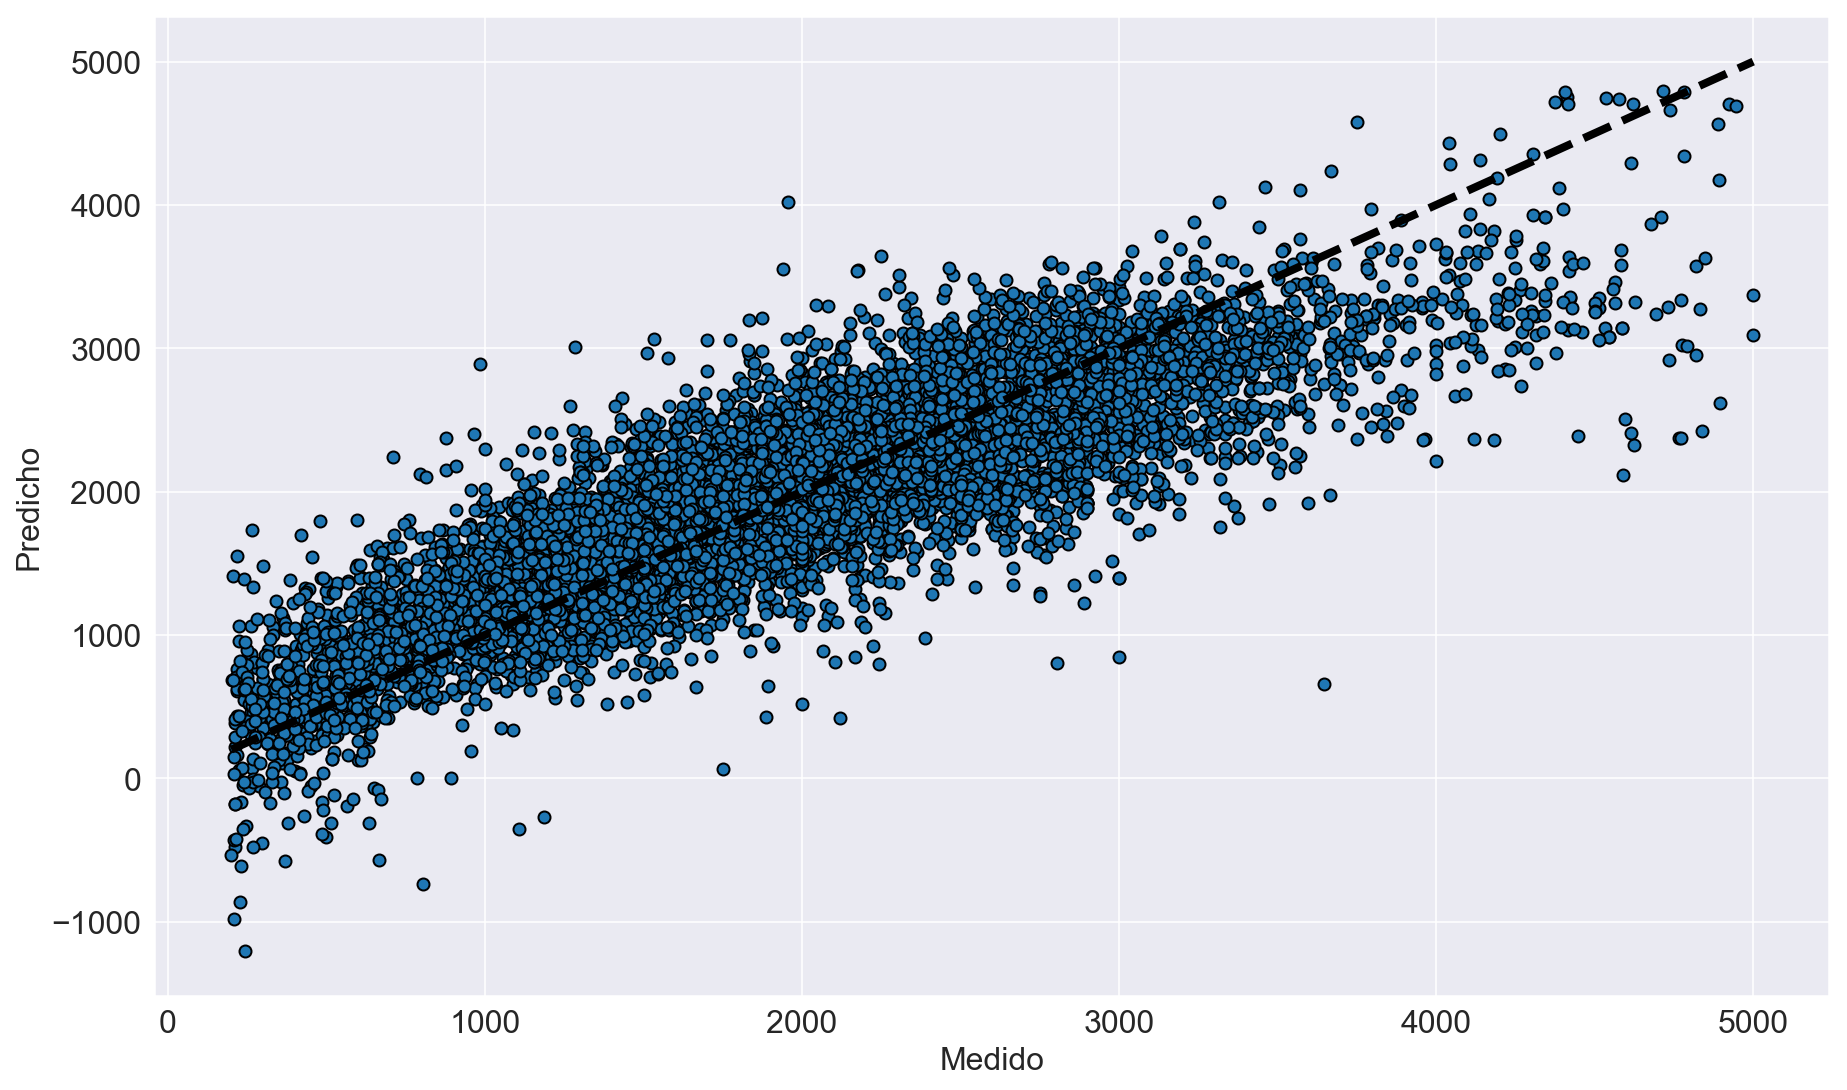

In [67]:
scatter(y_test, predictions2, y)

##### El uso de las parcelas es muy importante para el modelo.
##### Se mostró más arriba que intentamos utilizar dummies de la columna "Lugar" en lugar de las parcelas y no obteníamos R2 mejores a 0,56 / 0,57

### Primer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [68]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values

In [69]:
not_feature_cols

array(['rooms', 'parrilla', 'jardin', ..., '989/399', '989/400',
       '990/404'], dtype=object)

#### Armamos "X2_const":

In [70]:
X2_const = X_const.drop(not_feature_cols, axis=1)

In [71]:
X2_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  garage  lavadero  balcon  patio  amenities  estrenar  gimnasio  ...  989/396  989/397  989/401  990/397  990/400  990/408  991/410  993/398  994/397  994/419
0    1.0                 55.0                   40.0     0.0       1.0     0.0    1.0        0.0       0.0       0.0  ...        0        0        0        0        0        0        0        0        0        0
2    1.0                 55.0                   55.0     0.0       1.0     0.0    0.0        0.0       0.0       0.0  ...        0        0        0        0        0        0        0        0        0        0
7    1.0                 45.0                   40.0     0.0       1.0     0.0    0.0        0.0       1.0       0.0  ...        0        0        0        0        0        0        0        0        0        0

[3 rows x 1521 columns]

### Segunda aproximación con STATS MODEL - OLS

#### Usando "X2_const"

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X2_const, y)

In [73]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 197874.93482938656
EMC train: 213154.53320520808
R2:  0.7191517503617223
R2: train: 0.7191517503617223
R2: TEST: 0.6872131060055787


In [74]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     160.5
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:51:49   Log-Likelihood:            -2.0148e+05
No. Observations:               26804   AIC:                         4.038e+05
Df Residuals:                   26382   BIC:                         4.073e+05
Df Model:                         421                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1509.1136      7.932    190.251      0.000    1493.566    1524.661
surface_total_in_m2      -3.3606      0.052    -64.233      0.000      -3.463      -3.258
surface_covered_in_m2     1.5932      0.076     21.086      0.000       1.445       1.741
garage                  126.2013      6.134     20.573      0.000     114.178     138.225
lavadero                -29.6254      6.109     -4.849      0.000     -41.600     -17.651
balcon                   69.3373      6.090     11.386      0.000      57.401      81.273
patio                  -239.4895      7.632    -31.382      0.000    -254.448    -224.531
amenities                84.1291     10.823      7.773      0.000      62.916     105.342
estrenar                105.0854      9.653     10.887      0.000      86.165     124.005
gimnasio                220.5185     12.500     17.641      0.000     196.018     245.019
subte                   -22.0371     11.860     -1.858      0.063     -45.283       1.209
baulera                  52.2415      9.022      5.790      0.000      34.557      69.926
piscina_house           109.0328     14.591      7.473      0.000      80.434     137.631
piscina_depart          194.3771      9.948     19.538      0.000     174.878     213.877
1059/782               1.398e-10   1.22e-10      1.145      0.252   -9.95e-11    3.79e-10
1066/1311              1100.8697    259.117      4.249      0.000     592.987    1608.752
1066/1318              5.428e-11   7.76e-11      0.699      0.484   -9.79e-11    2.06e-10
1069/693                934.0569     65.896     14.175      0.000     804.898    1063.216
1071/700               -671.4813    317.132     -2.117      0.034   -1293.076     -49.886
1083/1480              -8.77e-11   2.27e-10     -0.387      0.699   -5.32e-10    3.57e-10
1084/1217              -2.24e-10   2.12e-10     -1.057      0.291    -6.4e-10    1.92e-10
1115/1626              -185.9040    103.110     -1.803      0.071    -388.005      16.197
1126/1645               650.1513    130.264      4.991      0.000     394.828     905.475
1126/1649                -4.3762    448.622     -0.010      0.992    -883.700     874.948
1127/1652              -319.0233    119.974     -2.659      0.008    -554.179     -83.868
1131/1649              -266.7408    119.987     -2.223      0.026    -501.923     -31.559
1131/1652               268.1026     79.521      3.371      0.001     112.238     423.968
1131/1653               839.0030     71.127     11.796      0.000     699.591     978.415
1131/1654              1463.9373    448.604      3.263      0.001     584.649    2343.226
1132/1636              5.392e-10   3.09e-10      1.744      0.081   -6.68e-11    1.15e-09
1132/1650               238.1825     54.691      4.355      0.000     130.985     345.381
1132/1651              

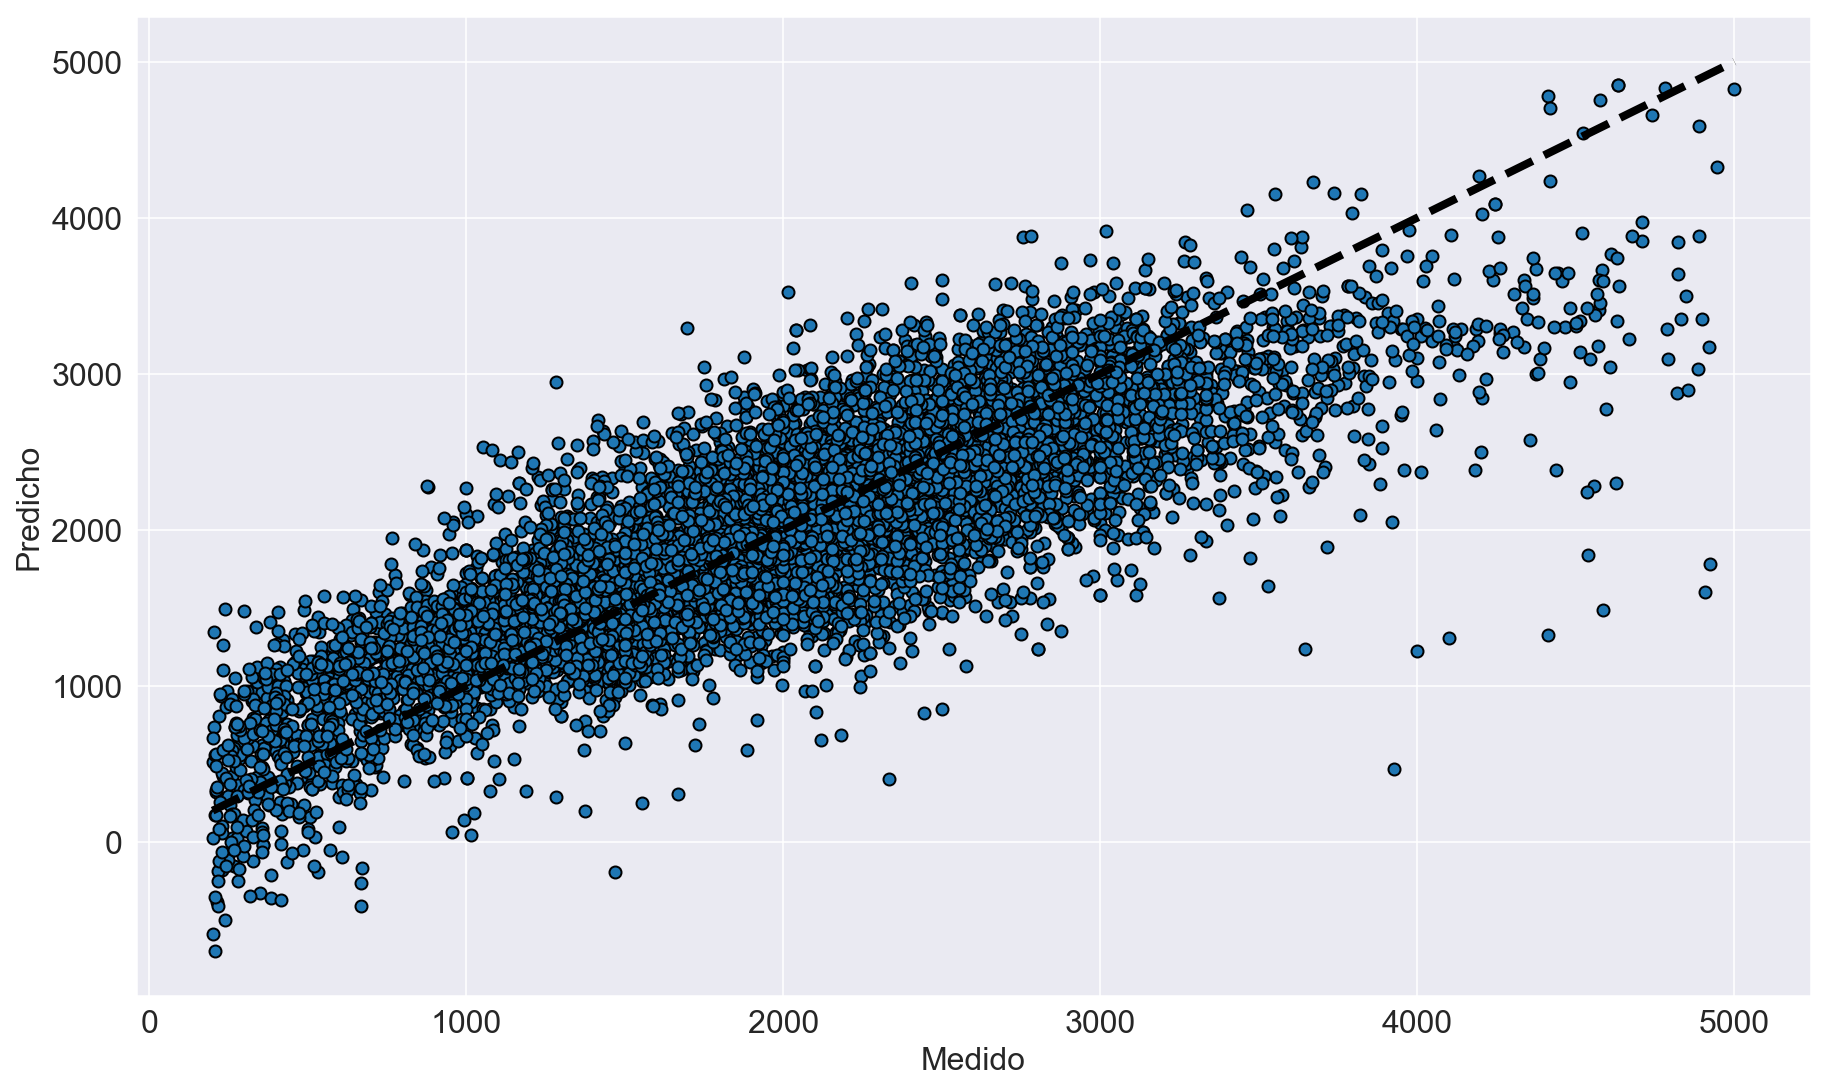

In [75]:
scatter(y_test, predictions2, y)

In [76]:
X2_const.columns

Index(['const', 'surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio',
       ...
       '989/396', '989/397', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1521)

#### Segunda eliminación de features con STATS MODEL - OLS
##### Este paso lo realizamos porque próximamente generaremos nuevas features y si la mantenemos todas ahora, luego las PC no logran alojar en memoria el procesamiento necesario


In [77]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['subte', '1059/782', '1066/1318', '1071/700', '1083/1480',
       '1084/1217', '1115/1626', '1126/1649', '1131/1649', '1132/1636',
       '1134/1647', '1134/1649', '1143/1586', '1169/1253', '1178/1511',
       '1178/1512', '1179/1699', '1181/1702', '1199/1721', '1207/1401',
       '1208/1399', '1220/1731', '1222/1731', '1224/1730', '1268/1179',
       '1290/1086', '1297/1551', '1297/1609', '1325/1511', '1332/1573',
       '1333/1543', '1335/1609', '1336/1577', '1337/1551', '1338/1620',
       '1341/1556', '1341/1606', '1343/1578', '1344/1566', '1344/1610',
       '1345/1566', '1346/1576', '1346/1578', '1347/1585', '1348/1579',
       '1348/1587', '1348/1595', '1348/1597', '1349/1581', '1350/1544',
       '1350/1576', '1350/1594', '1351/1593', '1352/1547', '1352/1565',
       '1355/1549', '1355/1550', '1356/1548', '1356/1574', '1357/1538',
       '1357/1560', '1359/1531', '1359/1545', '1360/1544', '1360/672',
       '1361/1531', '1361/1553', '1362/1509', '1362/1578', '1363/1550',

#### Armamos "X3_const":

In [78]:
X3_const = X2_const.drop(not_feature_cols, axis=1)

In [79]:
X3_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  garage  lavadero  balcon  patio  amenities  estrenar  gimnasio  ...  988/397  989/396  989/401  990/397  990/400  990/408  991/410  993/398  994/397  994/419
0    1.0                 55.0                   40.0     0.0       1.0     0.0    1.0        0.0       0.0       0.0  ...        0        0        0        0        0        0        0        0        0        0
2    1.0                 55.0                   55.0     0.0       1.0     0.0    0.0        0.0       0.0       0.0  ...        0        0        0        0        0        0        0        0        0        0
7    1.0                 45.0                   40.0     0.0       1.0     0.0    0.0        0.0       1.0       0.0  ...        0        0        0        0        0        0        0        0        0        0

[3 rows x 1242 columns]

### Tercera aproximación con STATS MODEL - OLS

#### Usando "X3_const"

In [80]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 200616.14968834832
EMC train: 214528.22954092294
R2:  0.712559765281112
R2: train: 0.712559765281112
R2: TEST: 0.6940491636966586


#### Observamos que el modelo mantiene el R2 de Test y Train luego de haber filtrado parámetros con Pvlues mayores al 1%

In [81]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     214.0
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:52:03   Log-Likelihood:            -2.0166e+05
No. Observations:               26804   AIC:                         4.039e+05
Df Residuals:                   26496   BIC:                         4.065e+05
Df Model:                         307                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1499.1874      7.777    192.781      0.000    1483.945    1514.430
surface_total_in_m2      -3.2979      0.051    -64.259      0.000      -3.399      -3.197
surface_covered_in_m2     1.5905      0.074     21.377      0.000       1.445       1.736
garage                  126.5274      6.119     20.678      0.000     114.534     138.521
lavadero                -24.3586      6.095     -3.996      0.000     -36.306     -12.411
balcon                   70.6925      6.099     11.591      0.000      58.739      82.646
patio                  -248.2171      7.620    -32.576      0.000    -263.152    -233.282
amenities                88.1465     10.861      8.116      0.000      66.859     109.434
estrenar                108.3593      9.629     11.254      0.000      89.487     127.232
gimnasio                202.5693     12.493     16.214      0.000     178.082     227.057
baulera                  44.9317      9.051      4.964      0.000      27.192      62.672
piscina_house           117.8143     14.522      8.113      0.000      89.350     146.279
piscina_depart          198.1487      9.909     19.997      0.000     178.727     217.571
1066/1311              1102.2860    260.333      4.234      0.000     592.020    1612.552
1069/693                923.2901     68.375     13.503      0.000     789.271    1057.309
1126/1645               603.4647    150.772      4.002      0.000     307.943     898.986
1127/1652              -265.5283    116.461     -2.280      0.023    -493.798     -37.259
1131/1652               277.0451     82.474      3.359      0.001     115.391     438.699
1131/1653               898.1248     77.459     11.595      0.000     746.300    1049.950
1131/1654              -1.87e-11   1.16e-11     -1.612      0.107   -4.14e-11    4.04e-12
1132/1650               179.3165     56.583      3.169      0.002      68.411     290.222
1132/1651               421.8976     50.965      8.278      0.000     322.004     521.792
1132/1652               423.8474     26.917     15.746      0.000     371.089     476.606
1132/1653               467.2586     35.088     13.317      0.000     398.484     536.034
1132/1654               949.7022     76.422     12.427      0.000     799.911    1099.494
1133/1651               328.1864     36.642      8.957      0.000     256.367     400.006
1133/1652               449.6500     16.433     27.363      0.000     417.441     481.859
1134/1652               459.1220     35.430     12.959      0.000     389.677     528.566
1178/1504              4.926e-11   8.72e-11      0.565      0.572   -1.22e-10     2.2e-10
1182/1704               340.0530    109.407      3.108      0.002     125.610     554.496
1183/1705               460.8582     96.232      4.789      0.000     272.238     649.478
1189/1711              

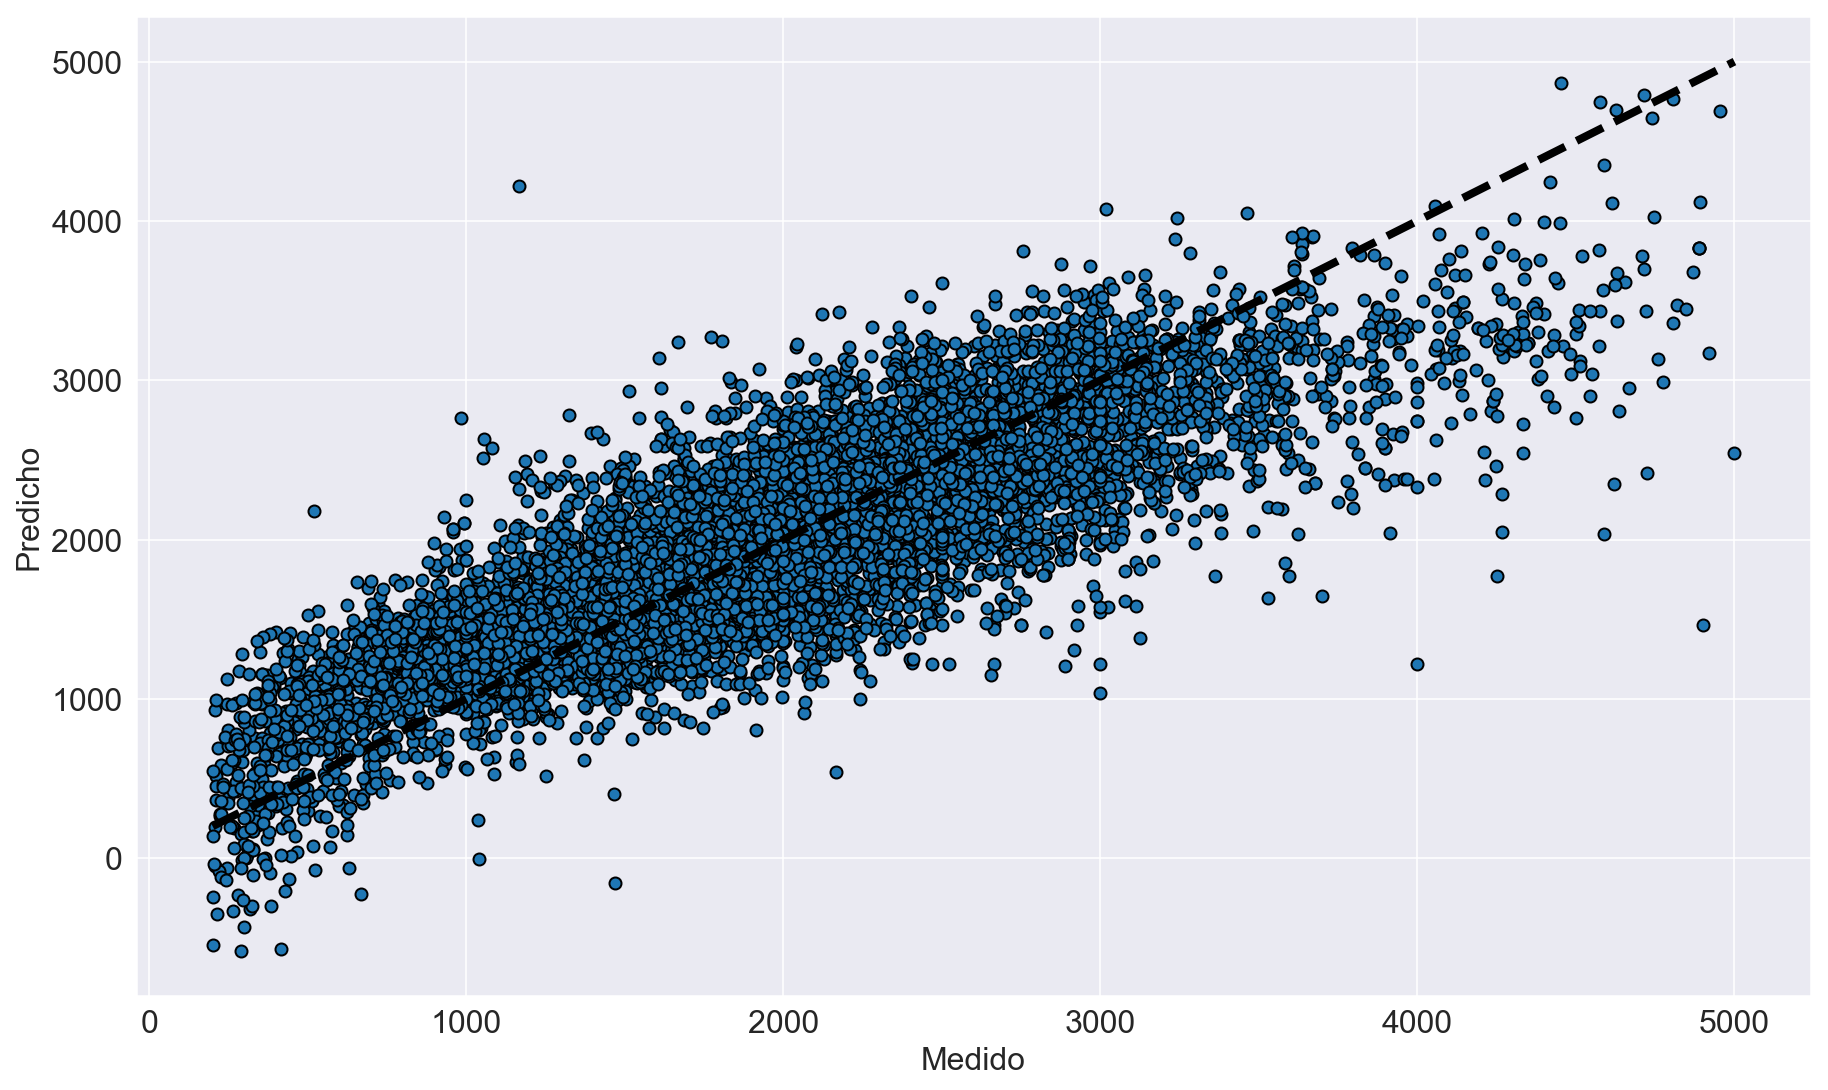

In [82]:
scatter(y_test, predictions2, y)

### 7) Probando diferentes Modelos

#### Armamo "X3" (sólo se requiere eliminar la columna "const")

In [83]:
X3 = X3_const.drop(["const"], axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X3, y)

#### 7-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [85]:
# X_train, X_test, y_train, y_test
# SIEMPRE NORMALIZAMOS CUANDO HACEMOS REGULARIZACIÓN (RIGDE, LASSO, ETC..) PORQUE SINO COMO LOS BETAS DE CADA
# FEATURE ESTÁN EN ESCALAS DIFERENTE, PENALIZARÍA MAS A FEATURES EN RANGOS MUY GRANDES,
# ES DECIR, PENALIZARÍA DIFERENTE A CADA FEATURE
# ADEMÁS, AYUDA AL TIEMPO DE PROCESAMIENTO
# OJO QUE LOS BETA QUE OBTENEMOS ESTARÁN TAMBIÉN EN OTRA ESCALA, TAMBIÉN ESTARÁN NORMALIZADOS

rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

# Ajustamos nuevamente, esta vez con regularizacion (RIDGE)
ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)
# SUPUESTAMENTE EL MÉTODO PREDICT TOMA LOS X Y LOS NORMALIZA ANTES DE PREDECIR, SI ASÍ LO SETIE EN EL MODELO.
# SINO NO FUNCIONARÍA, O SI YO QUISIERA ARMAR EL MODELO CON LOS BETAS Y CORFICIENTES YO DEBERÍA NORMALIZAR LAS X

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))


r^2 Train: 0.7098131580531443
r^2 TEST: 0.7019377584064472


In [86]:
ridge_model.alpha

0.01

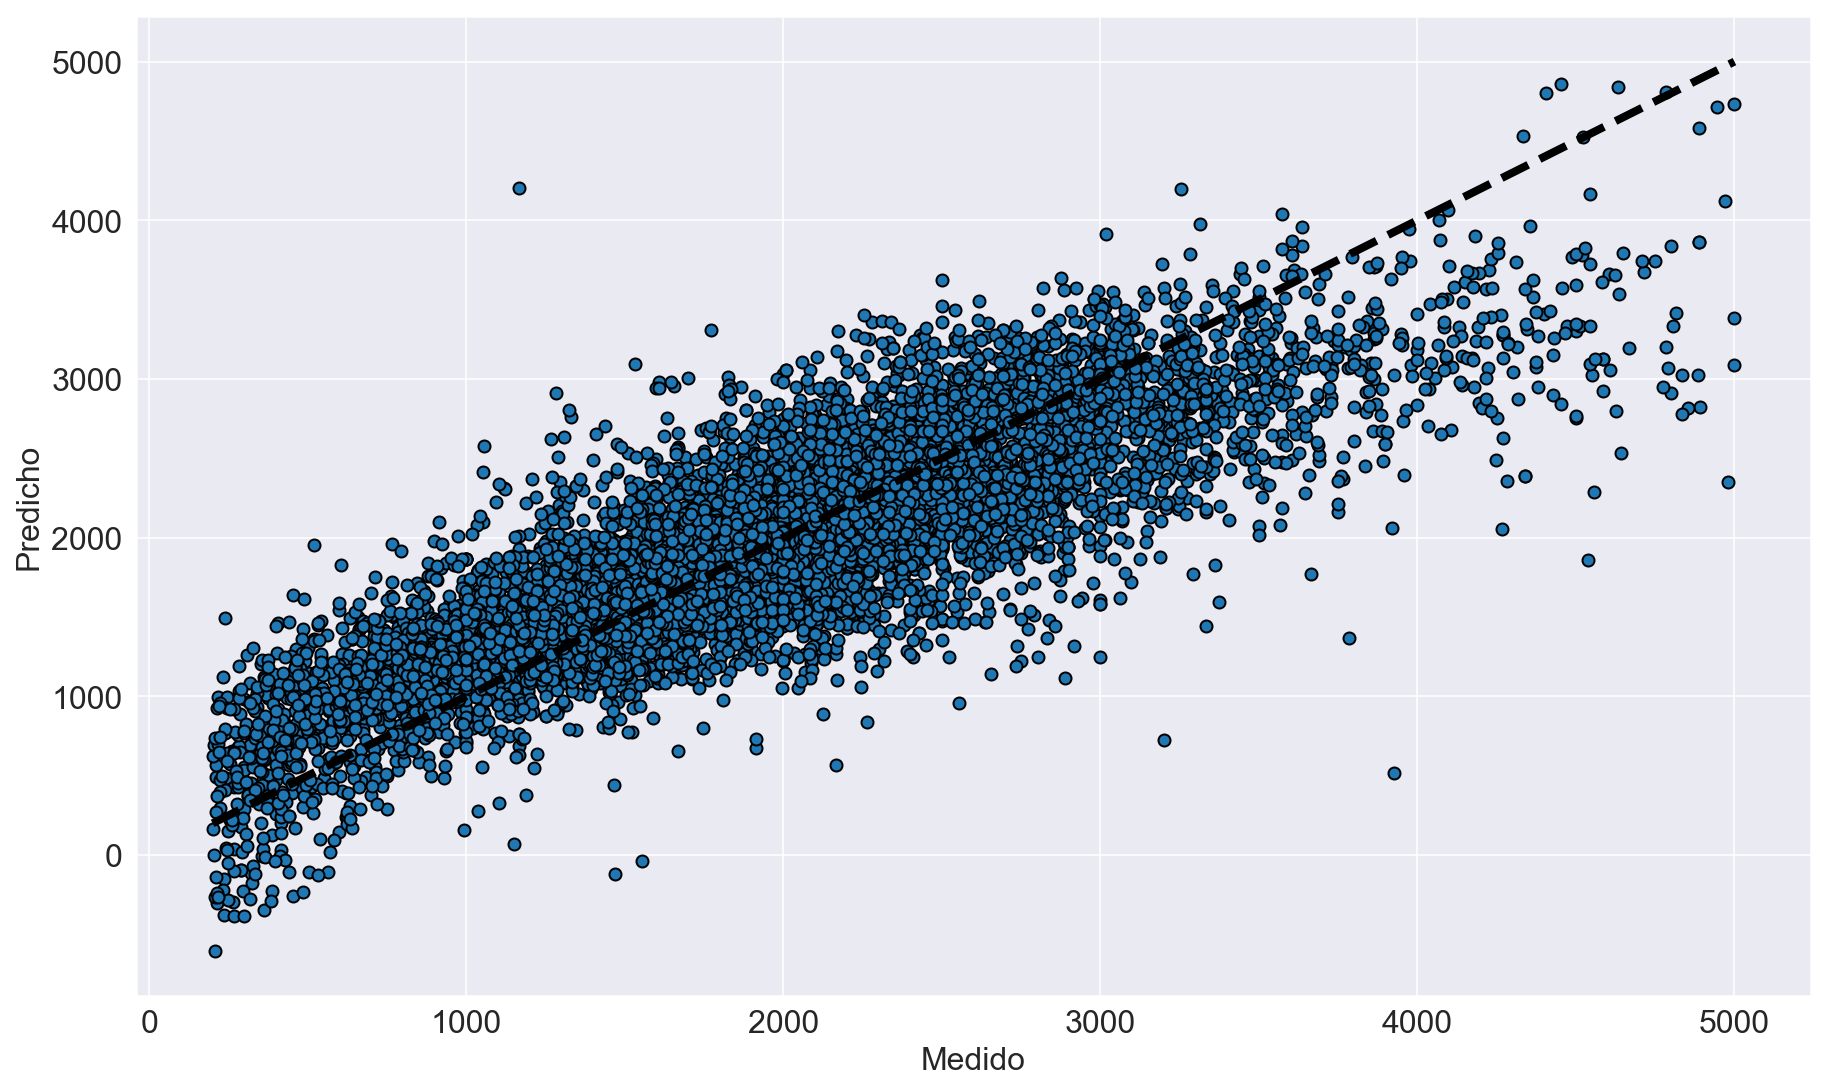

In [87]:
scatter(y_test, predictions2, y)

#### 7-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [88]:
# X_train, X_test, y_train, y_test

lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

# Ajustamos nuevamente, esta vez con regularizacion (LASSO)
lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))


r^2 Train: 0.7075469982647897
r^2 TEST: 0.699980088742957


In [89]:
lasso_model.alpha

0.01

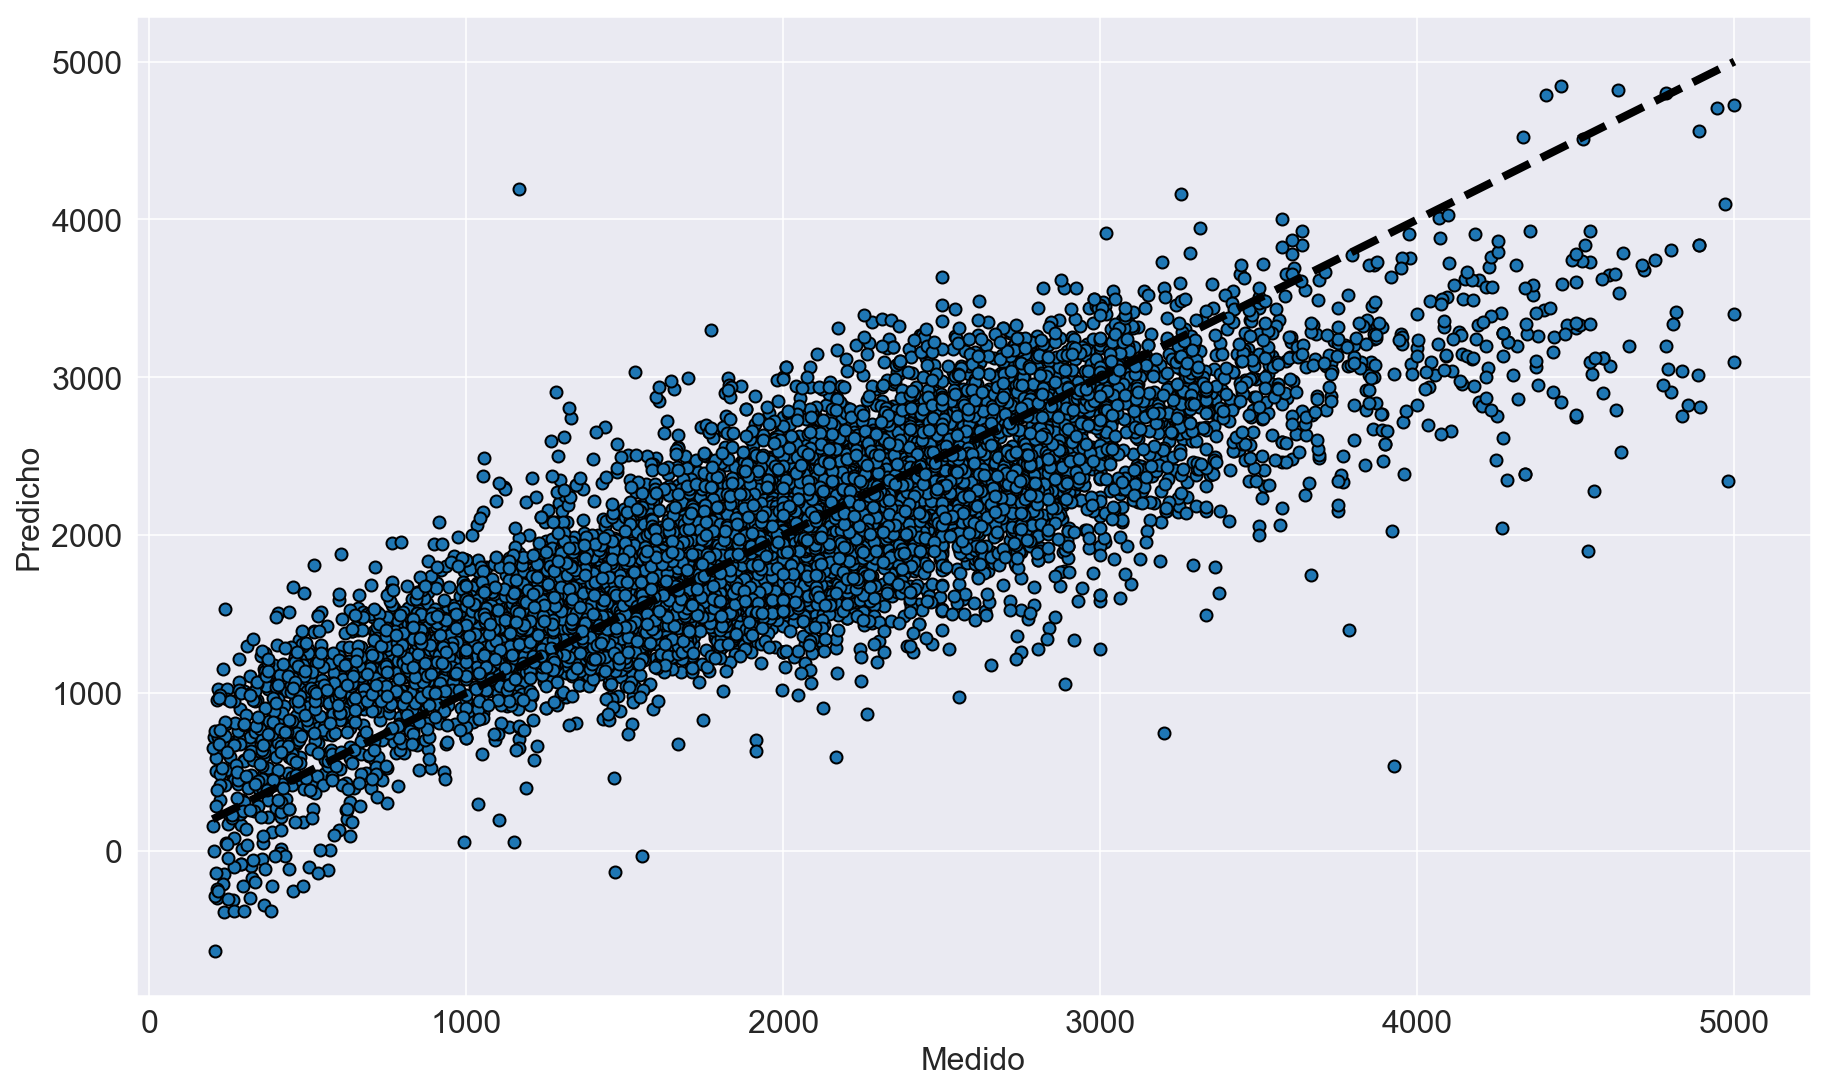

In [90]:
scatter(y_test, predictions2, y)

### 8) Vamos a crear una Feature que es el cuadrado de la feature "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamo "X3_cuad"

In [91]:
X3.shape

(35739, 1241)

In [92]:
X3.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '988/397', '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1241)

In [93]:
sup_x_sup = X3.surface_total_in_m2 * X3.surface_total_in_m2
sup_x_sup.name

'surface_total_in_m2'

In [94]:
sup_x_sup.rename("sup_x_sup", axis=1, inplace=True)
sup_x_sup.name

'sup_x_sup'

In [95]:
X3_cuad = pd.concat([X3, sup_x_sup],axis=1)
X3_cuad.shape

(35739, 1242)

In [96]:
X3_cuad.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419', 'sup_x_sup'], dtype='object', length=1242)

#### Probamos los diferentes modelos incluyendo nuestra nueva feature ("sup_x_sup"):
### "X3_cuad"

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad, y)

#### 8-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [98]:
rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))

r^2 Train: 0.7253387780365693
r^2 TEST: 0.6989755606197964


In [99]:
ridge_model.alpha

0.01

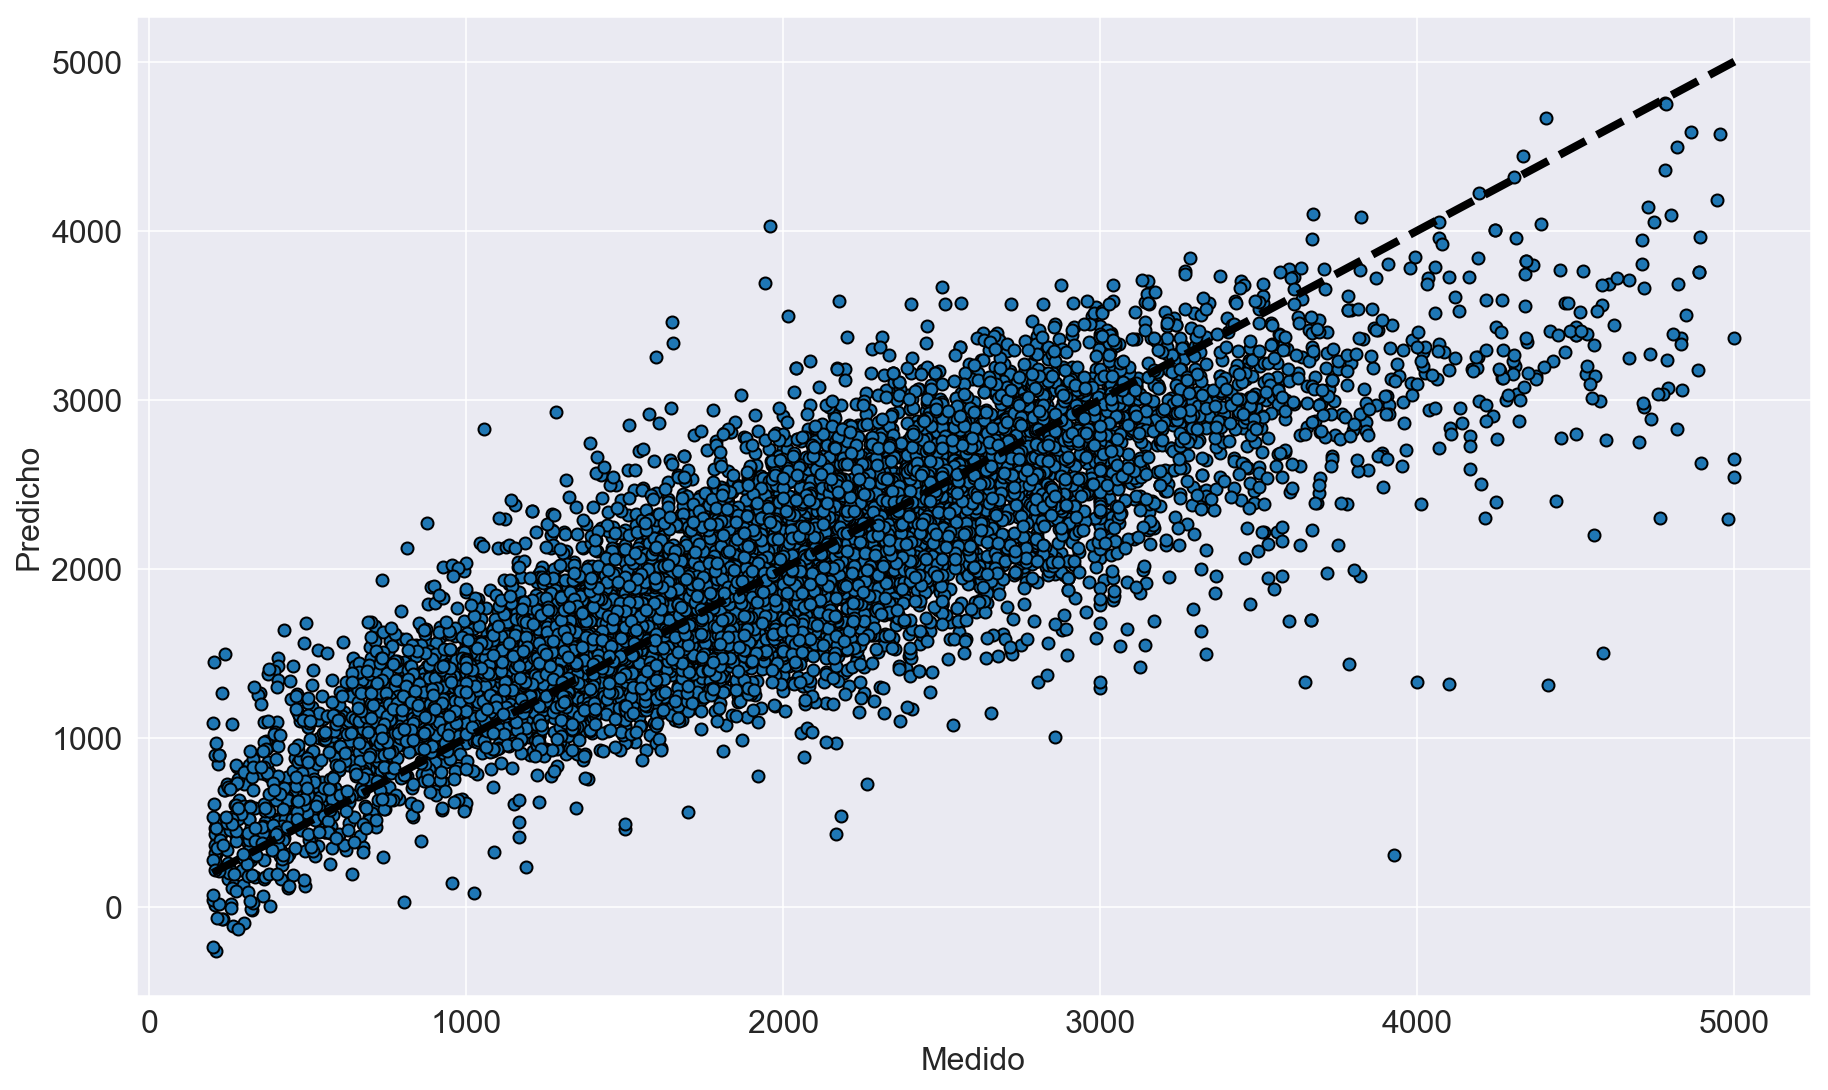

In [100]:
scatter(y_test, predictions2, y)

#### 8-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [101]:
lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))

r^2 Train: 0.7244717711656821
r^2 TEST: 0.6987704042549892


In [102]:
lasso_model.alpha

0.01

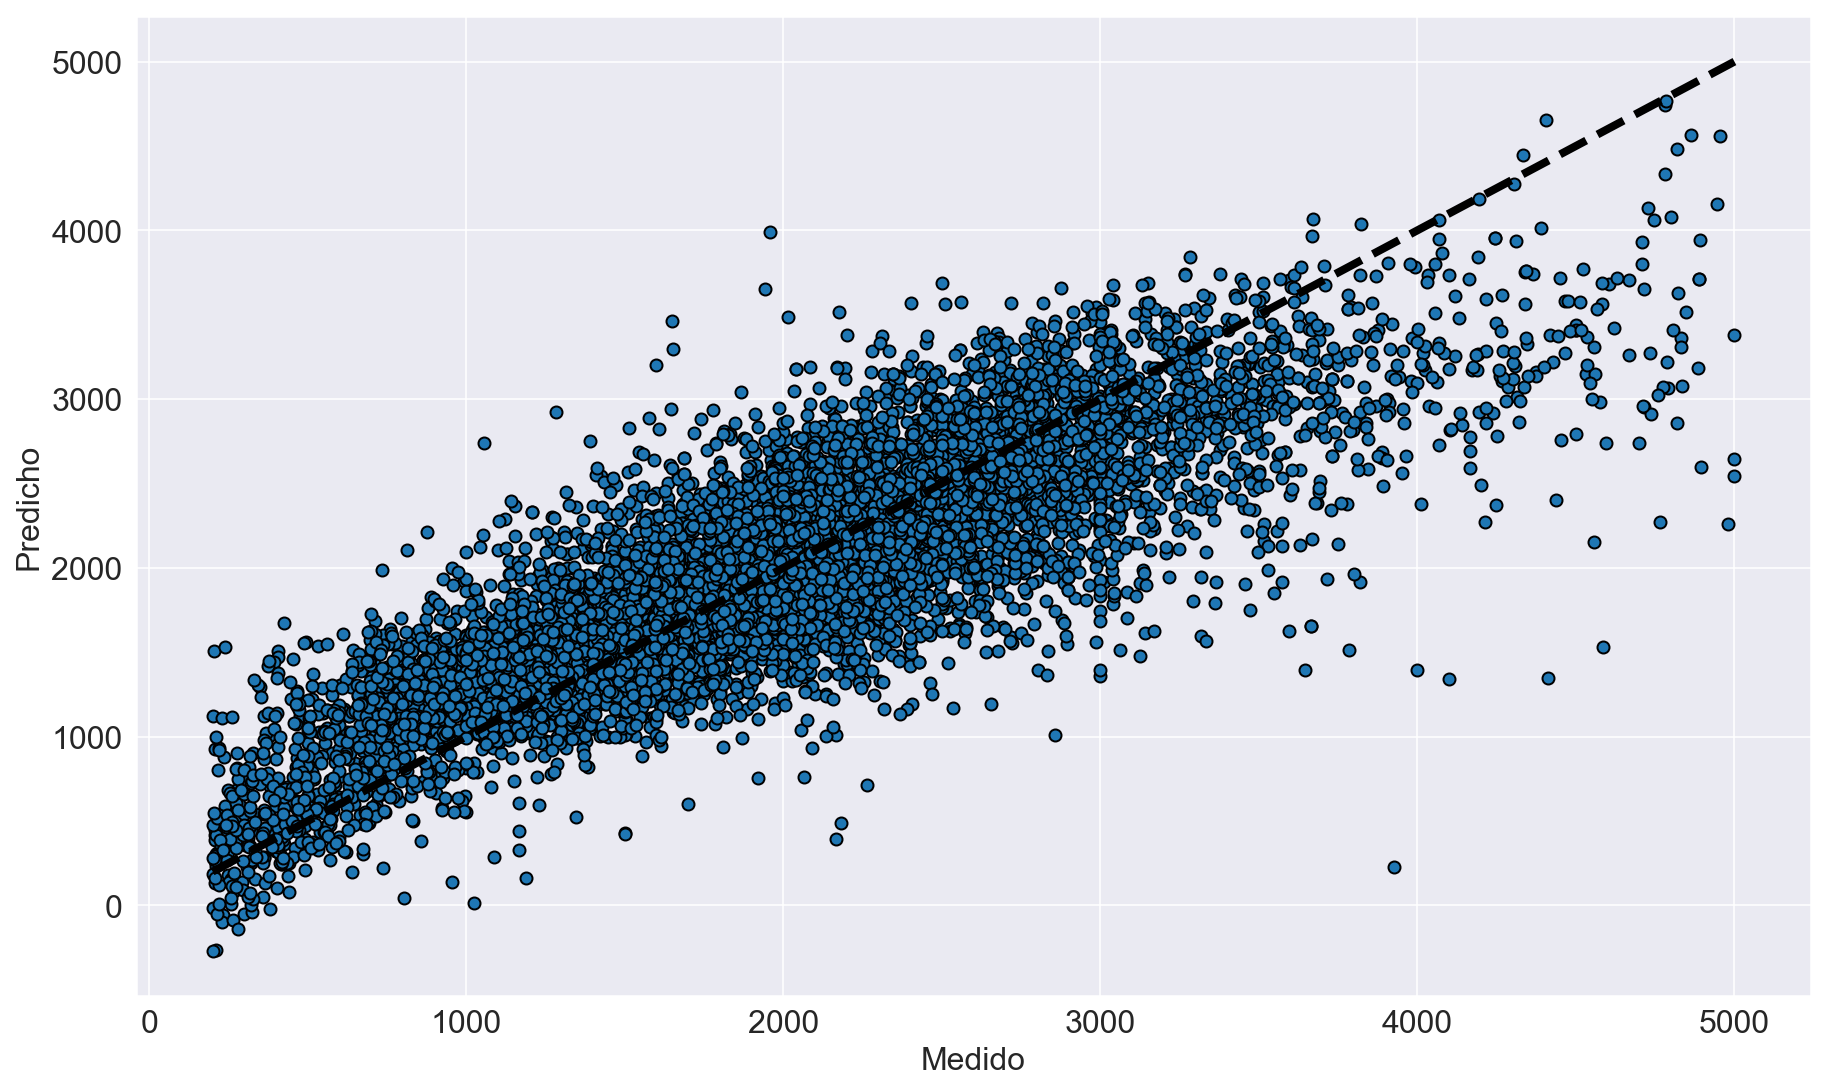

In [103]:
scatter(y_test, predictions2, y)

#### Para ambos modelos no hemos notado una variación significativa



#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### Importamos algunas librerías más requeridas para este punto

In [104]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

from sklearn.preprocessing import StandardScaler

# KFold: Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# OBJETO PARA CROSS-VALIDATION (K-Folds cross-validator) 
cv = KFold(3, shuffle=True)
# LO BUENO DE USAR ESTE OBJETO, ES QUE PODRÍA USARLO PARA HACER SIEMPRE LAS MISMAS PARTICIONES

#### 8-c) Ridge Regression CV (Cross Validation)

In [105]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))

{'alpha': 0.01, 'scores': array([0.71338474, 0.70391395, 0.71333471]), 'mean_score': 0.7102111328488373}


In [106]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.6989755606197954

#### 8-d) Lasso Regression CV (Cross Validation)

In [107]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.72009371, 0.70190761, 0.71224053]), 'mean_score': 0.7114139497060391, 'zero_coefs': 934}


In [108]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.6987704042549892

#### Se verificó para diferentes particiones los R2 Test y Train

### 9) Creación de Features Relacionales

#### Vamos a crear Features relacionando las columnas Dummie de las Parcelas con la columnas "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamos "X3_cuad_relac"

In [109]:
X3_cuad.shape

(35739, 1242)

In [110]:
X3_cuad.columns[0:20]

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', '1066/1311', '1069/693', '1126/1645', '1127/1652', '1131/1652', '1131/1653', '1131/1654', '1132/1650'], dtype='object')

In [111]:
X3_cuad.columns[-1]

'sup_x_sup'

#### En base a las dos celdas anteriores SELECCIONAR A MANO LAS QUE NO VOY A MULTIPLICAR (las que no son dummies de posición y que hayan quedado luego de las sucesivas eliminaciones de fueatures con Pvalue > 0,01)

In [112]:
relac = X3_cuad.drop(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', 'sup_x_sup'],
                     axis=1)

In [113]:
relac.shape

(35739, 1229)

In [114]:
X3_cuad.surface_total_in_m2.shape

(35739,)

In [115]:
relaciones = relac.mul(X3_cuad.surface_total_in_m2, axis=0)
relaciones.shape

(35739, 1229)

In [116]:
relaciones[relaciones.columns[0]]

0         0.0
2         0.0
7         0.0
8         0.0
12        0.0
         ... 
118454    0.0
118464    0.0
118471    0.0
118482    0.0
118503    0.0
Name: 1066/1311, Length: 35739, dtype: float64

In [117]:
relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0]

10061     42.0
18009    110.0
47501     95.0
Name: 1066/1311, dtype: float64

In [118]:
# PEQUEÑA VERIFICACIÓN
display(X3_cuad.surface_total_in_m2[(relaciones[relaciones.columns[0]])>0])
print("")
display(relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0])  # miro cóm queda

10061     42.0
18009    110.0
47501     95.0
Name: surface_total_in_m2, dtype: float64

10061     42.0
18009    110.0
47501     95.0
Name: 1066/1311, dtype: float64

In [119]:
columnas = list(range(relaciones.columns.size))
columnas[-1]

1228

In [120]:
relaciones.set_axis(columnas, axis=1, inplace=True)   # renombro las columnas nuevas (las relacionales)

In [121]:
relaciones.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228], dtype='int64', length=1229)

In [122]:
relaciones.shape

(35739, 1229)

In [123]:
X3_cuad_relac = pd.concat([X3_cuad, relaciones],axis=1)
X3_cuad_relac.shape

(35739, 2471)

In [124]:
X3_cuad_relac.columns

Index([  'surface_total_in_m2', 'surface_covered_in_m2',                'garage',              'lavadero',                'balcon',                 'patio',             'amenities',              'estrenar',              'gimnasio',               'baulera',
       ...
                          1219,                    1220,                    1221,                    1222,                    1223,                    1224,                    1225,                    1226,                    1227,                    1228], dtype='object', length=2471)

#### Probamos los diferentes modelos incluyendo nuestras nuevas features RELACIONALES:
### "X3_cuad_relac"

#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### con "X3_cuad_relac"

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac, y)

#### 9-a) Ridge Regression CV (Cross Validation)

In [126]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))


{'alpha': 0.01, 'scores': array([0.67630179, 0.70738453, 0.69703771]), 'mean_score': 0.6935746760044976}


In [127]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7004794790052193

#### 9-b) Lasso Regression CV (Cross Validation)

In [128]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.72053013, 0.70381156, 0.70248076]), 'mean_score': 0.7089408189307593, 'zero_coefs': 2029}


In [129]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7014436605381218

#### 9-c) Stats Model Linear

#### Armamos "X3_cuad_relac_const"

In [130]:
# USANDO statsmodel
# Tenemos que agregar explícitamente a una constante:
X3_cuad_relac_const = sm.add_constant(X3_cuad_relac)
X3_cuad_relac_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  garage  lavadero  balcon  patio  amenities  estrenar  gimnasio  ...  1219  1220  1221  1222  1223  1224  1225  1226  1227  1228
0    1.0                 55.0                   40.0     0.0       1.0     0.0    1.0        0.0       0.0       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2    1.0                 55.0                   55.0     0.0       1.0     0.0    0.0        0.0       0.0       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
7    1.0                 45.0                   40.0     0.0       1.0     0.0    0.0        0.0       1.0       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[3 rows x 2472 columns]

In [131]:
X3_cuad_relac_const = X3_cuad_relac_const.astype("int", copy=True)   # lo paso a int sino no me da la memoria

In [132]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print("EMC train:", mean_squared_error(y_train, predictions))
print("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 188238.71775503113
EMC train: 203509.57846815456
R2:  0.7300569980230998
R2: train: 0.7300569980230998
R2: test: 0.7104293785912243


##### SE OBSERVA QUE BAJÓ EL R2 TEST

In [133]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     128.1
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:59:19   Log-Likelihood:            -2.0081e+05
No. Observations:               26804   AIC:                         4.027e+05
Df Residuals:                   26249   BIC:                         4.073e+05
Df Model:                         554                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1661.29

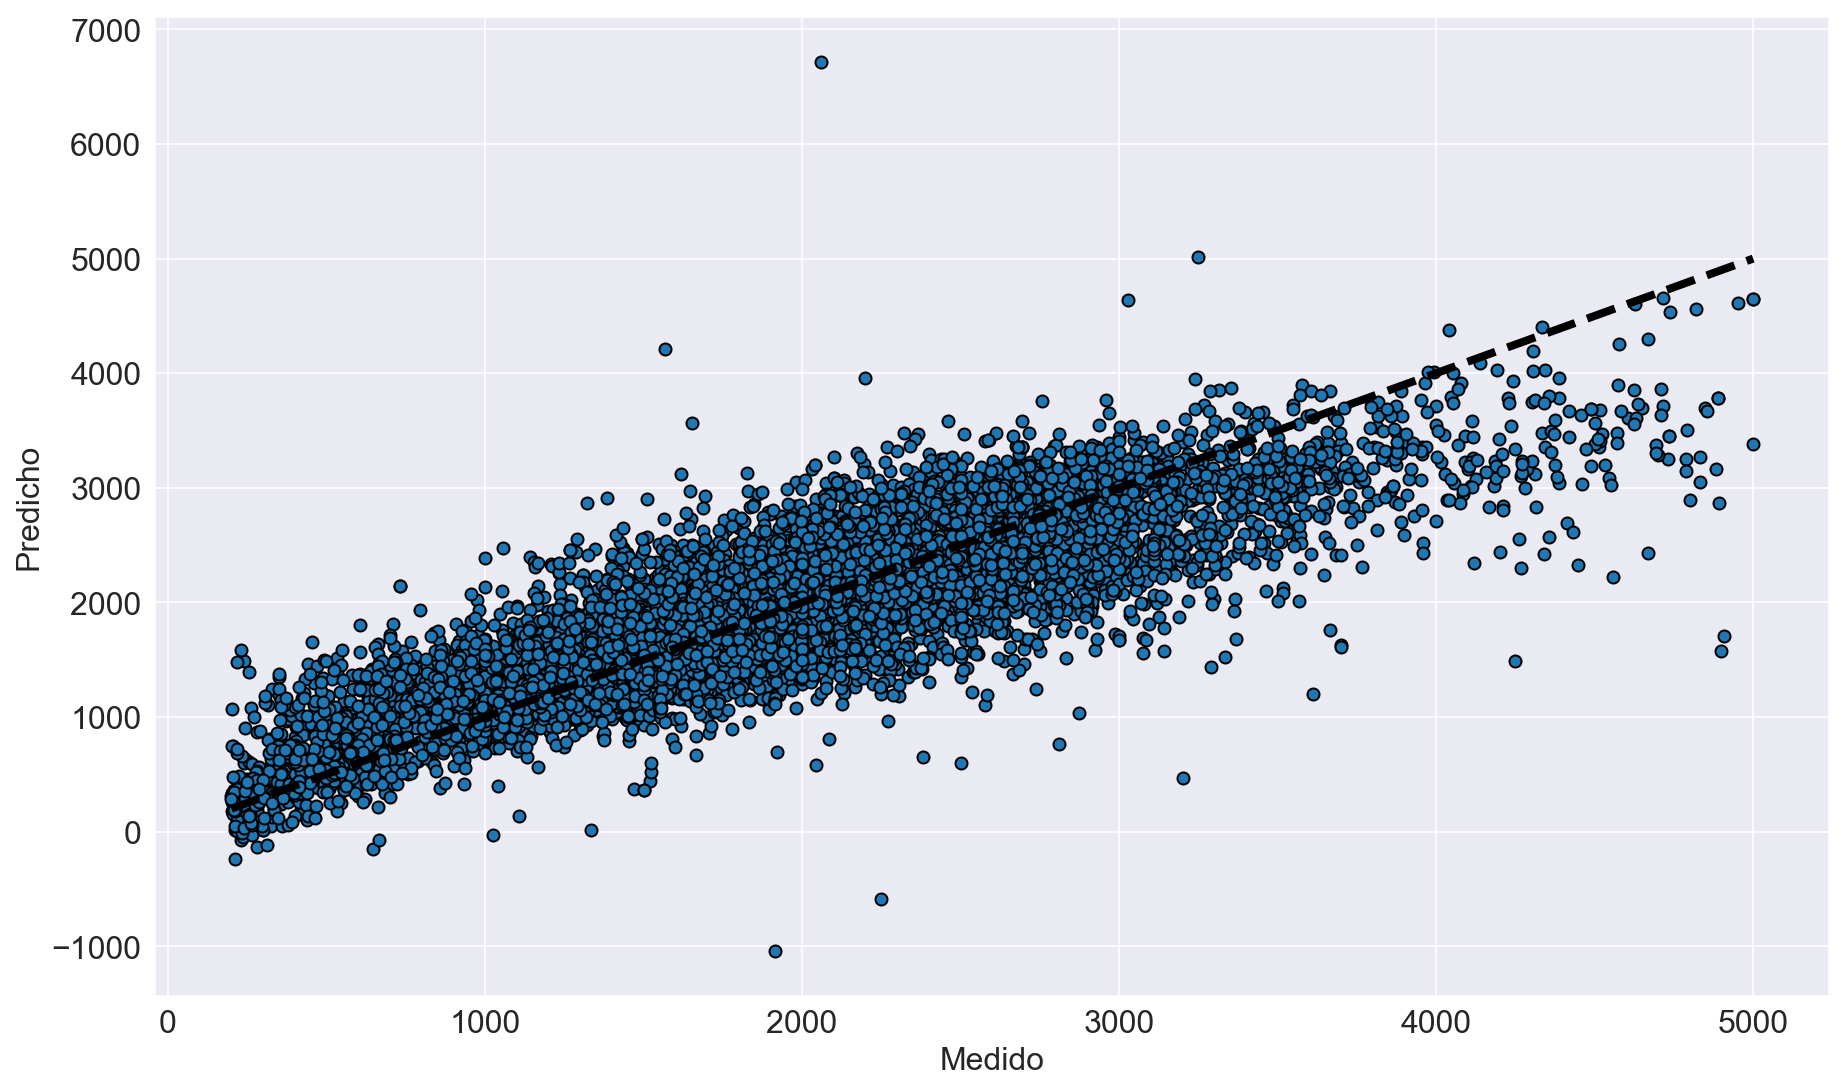

In [134]:
scatter(y_test, predictions2, y)

Homocedasticidad (varianza igual) de residuos


C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning:

invalid value encountered in sqrt

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning:

divide by zero encountered in true_divide




 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   2.546096e+03
p-value                         1.429718e-01
f-value                         4.973070e+00
f p-value                      2.741230e-269

 Goldfeld-Quandt test ----
                value
F statistic  0.990428
p-value      0.707417

 Residuals plots ----


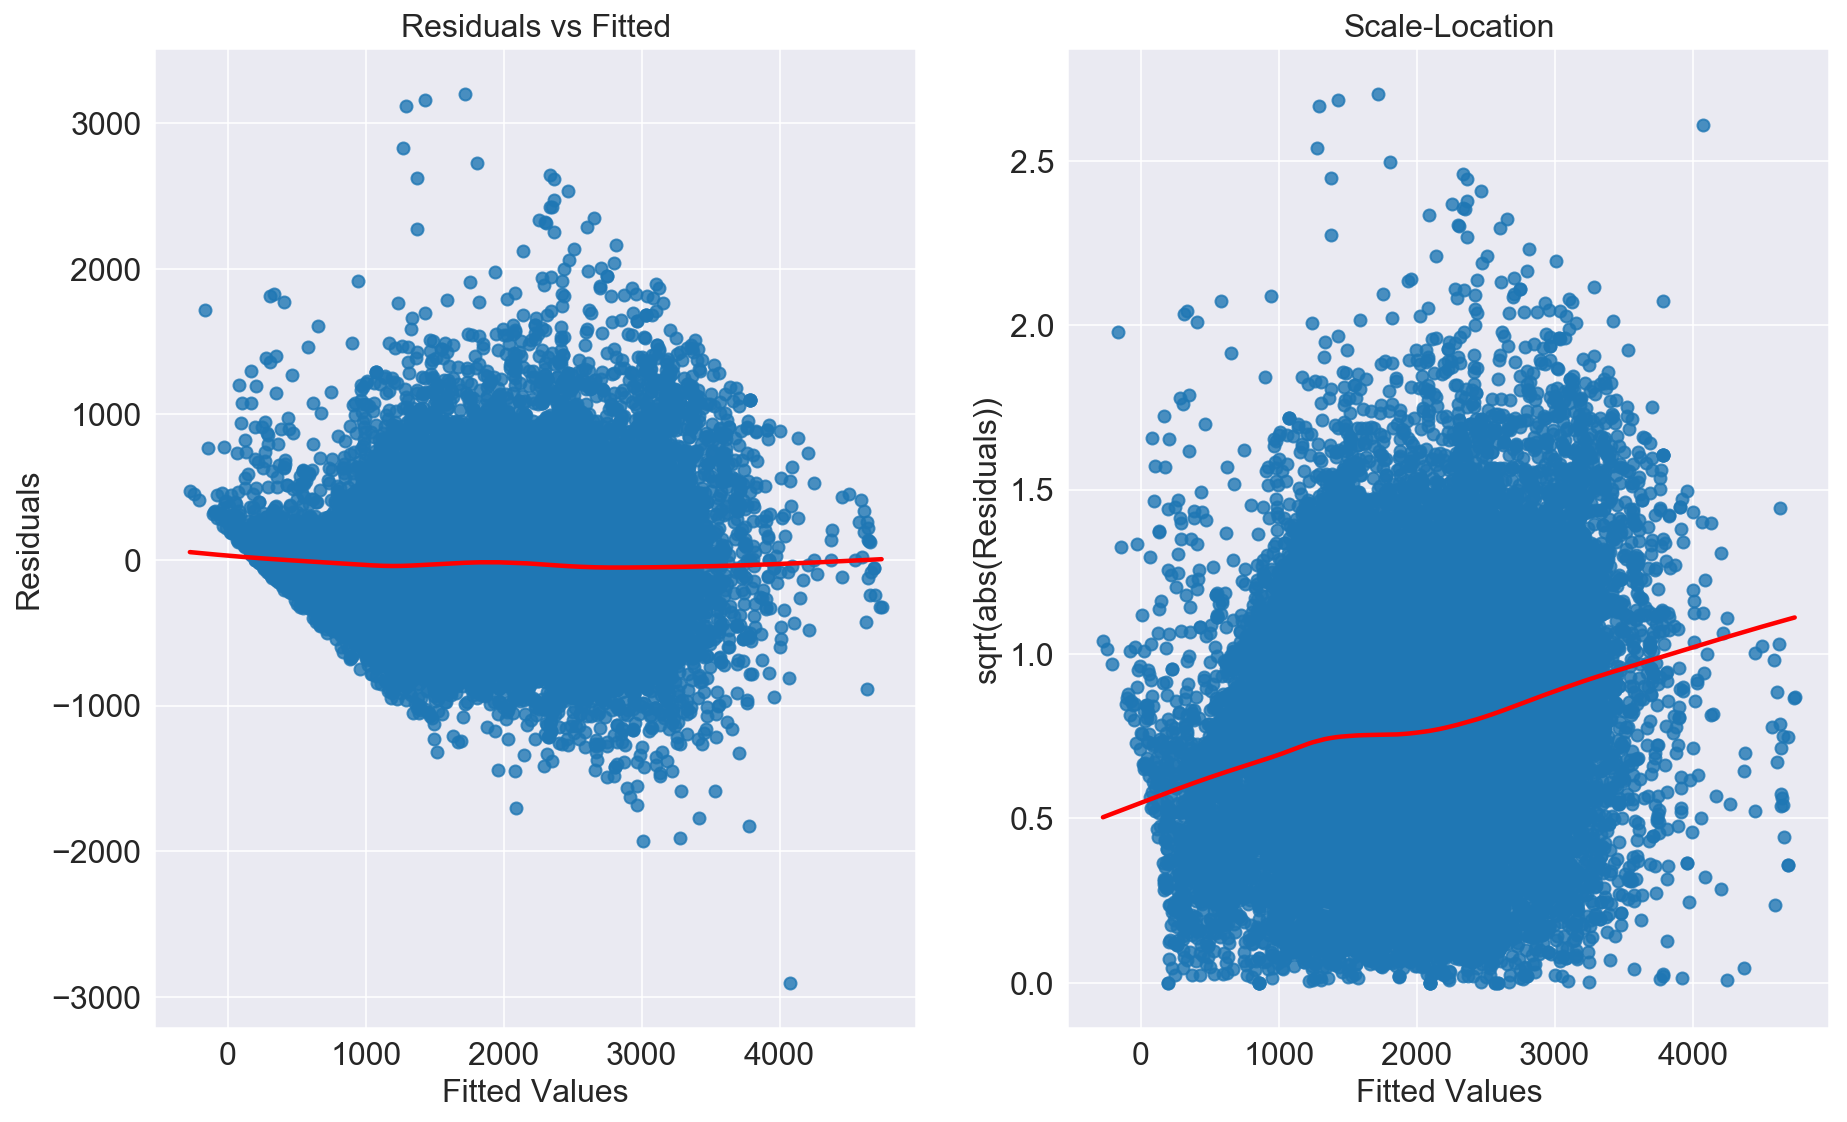

In [135]:
print ("Homocedasticidad (varianza igual) de residuos")
homoscedasticity_test(model)

#### Tercer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [136]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['lavadero', '1066/1311', '1127/1652', '1131/1654', '1183/1705',
       '1189/1712', '1190/1713', '1191/1714', '1193/1716', '1194/1716',
       '1194/1717', '1195/1714', '1195/1716', '1195/1717', '1195/1718',
       '1219/1731', '1221/1731', '1227/1730', '1303/1544', '1341/1563',
       '1341/1574', '1341/1615', '1343/1577', '1347/1572', '1347/1594',
       '1347/1596', '1348/1594', '1348/1596', '1350/1596', '1355/1582',
       '1355/1585', '1356/1566', '1356/1584', '1358/1537', '1358/1558',
       '1359/1546', '1359/1557', '1359/1568', '1360/1540', '1360/1563',
       '1361/666', '1362/1557', '1363/1547', '1365/1565', '1365/1573',
       '1366/1526', '1366/1558', '1367/1543', '1369/1512', '1369/1542',
       '1370/1557', '1370/1560', '1370/1563', '1370/1564', '1371/1542',
       '1372/1534', '1372/1555', '1372/1563', '1373/1557', '1374/1536',
       '1374/1550', '1375/1549', '1375/1554', '1376/1547', '1376/1550',
       '1376/1553', '1377/1444', '1377/1547', '1379/1530', '1395/1

#### Armamos "X4_cuad_relac_const"

In [137]:
X4_cuad_relac_const = X3_cuad_relac_const.drop(not_feature_cols, axis=1)

In [138]:
X4_cuad_relac_const.head(3)

const  surface_total_in_m2  surface_covered_in_m2  garage  balcon  patio  amenities  estrenar  gimnasio  baulera  ...  1219  1220  1221  1222  1223  1224  1225  1226  1227  1228
0      1                   55                     40       0       0      1          0         0         0        0  ...     0     0     0     0     0     0     0     0     0     0
2      1                   55                     55       0       0      0          0         0         0        0  ...     0     0     0     0     0     0     0     0     0     0
7      1                   45                     40       0       0      0          0         1         0        0  ...     0     0     0     0     0     0     0     0     0     0

[3 rows x 1865 columns]

#### STATS MODEL con "X4_cuad_relac_const"

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac_const, y)

In [140]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT

EMC train: 196637.17344464237
EMC train: 210446.7240965657
R2:  0.716214278860555
R2: train: 0.716214278860555
R2: test: 0.7062513583296399


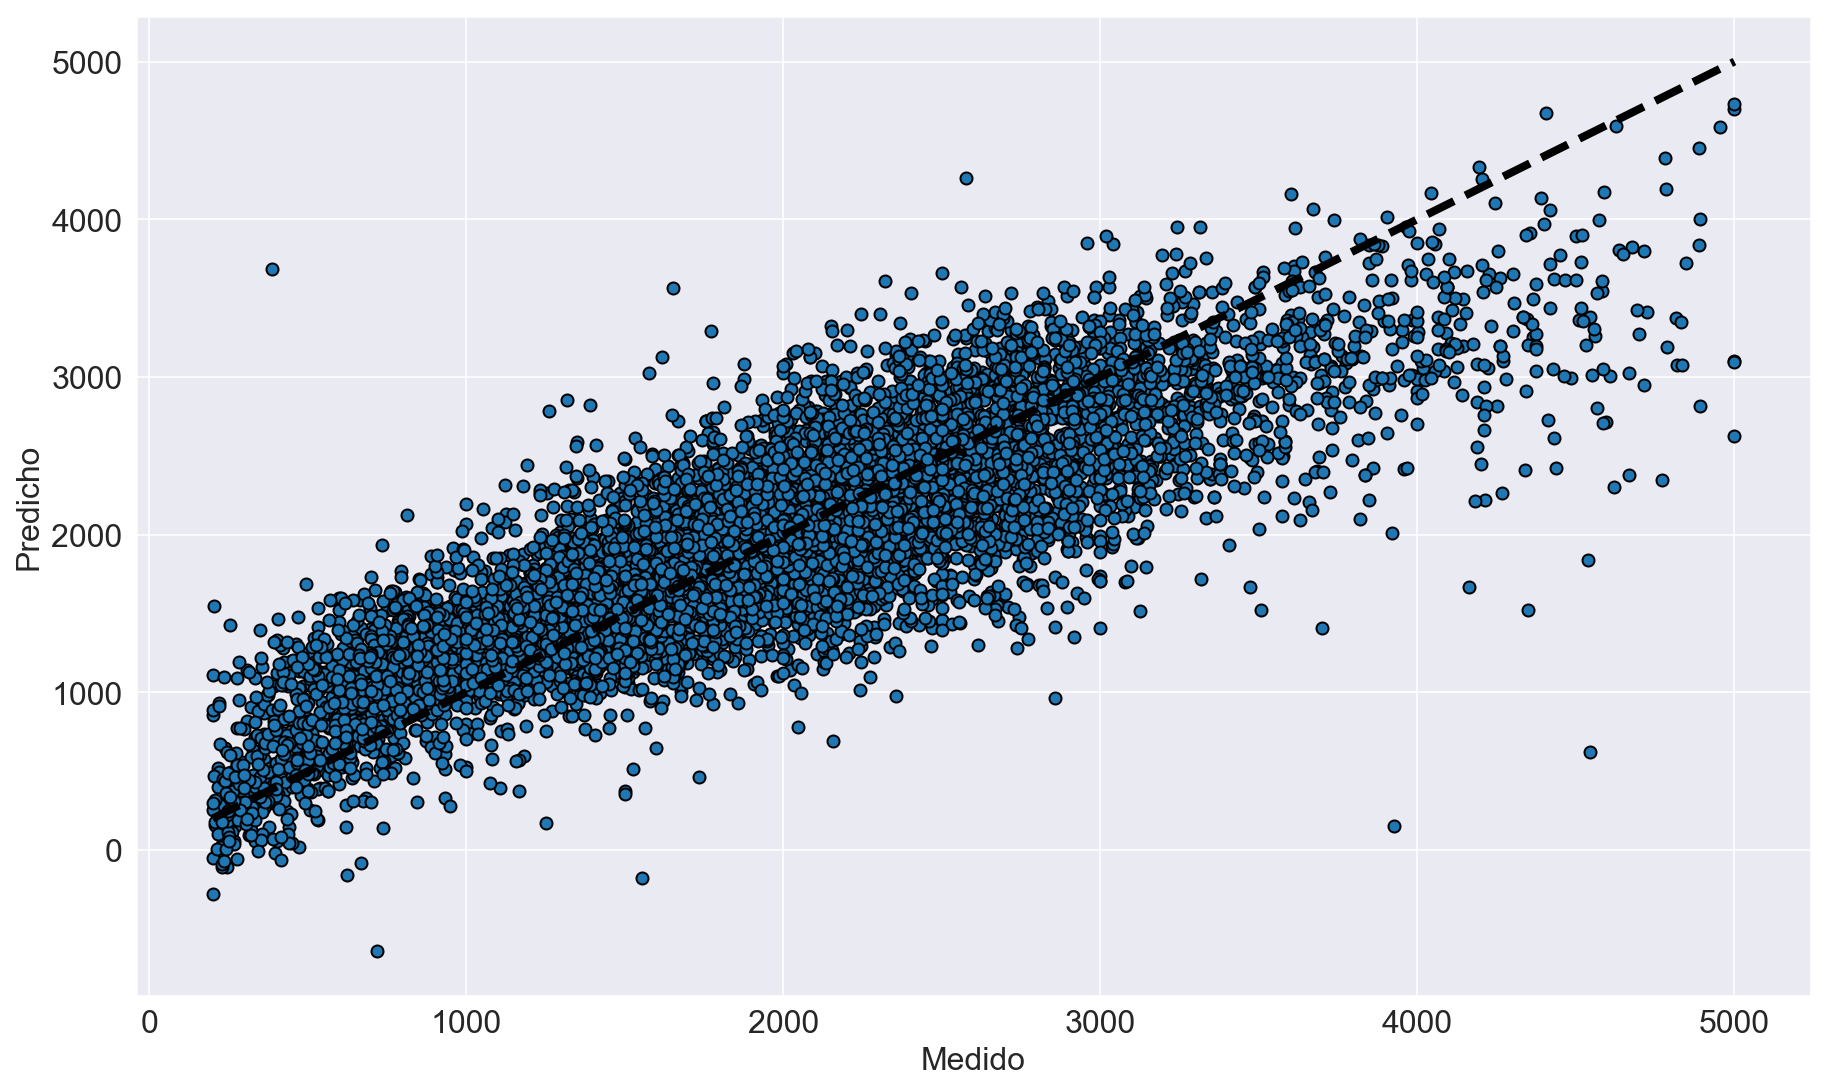

In [141]:
scatter(y_test, predictions2, y)

Homocedasticidad (varianza igual) de residuos


C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning:

invalid value encountered in sqrt

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning:

divide by zero encountered in true_divide




 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.942372e+03
p-value                         1.008197e-01
f-value                         7.884024e+00
f p-value                      1.659182e-265

 Goldfeld-Quandt test ----
                value
F statistic  0.981875
p-value      0.852852

 Residuals plots ----


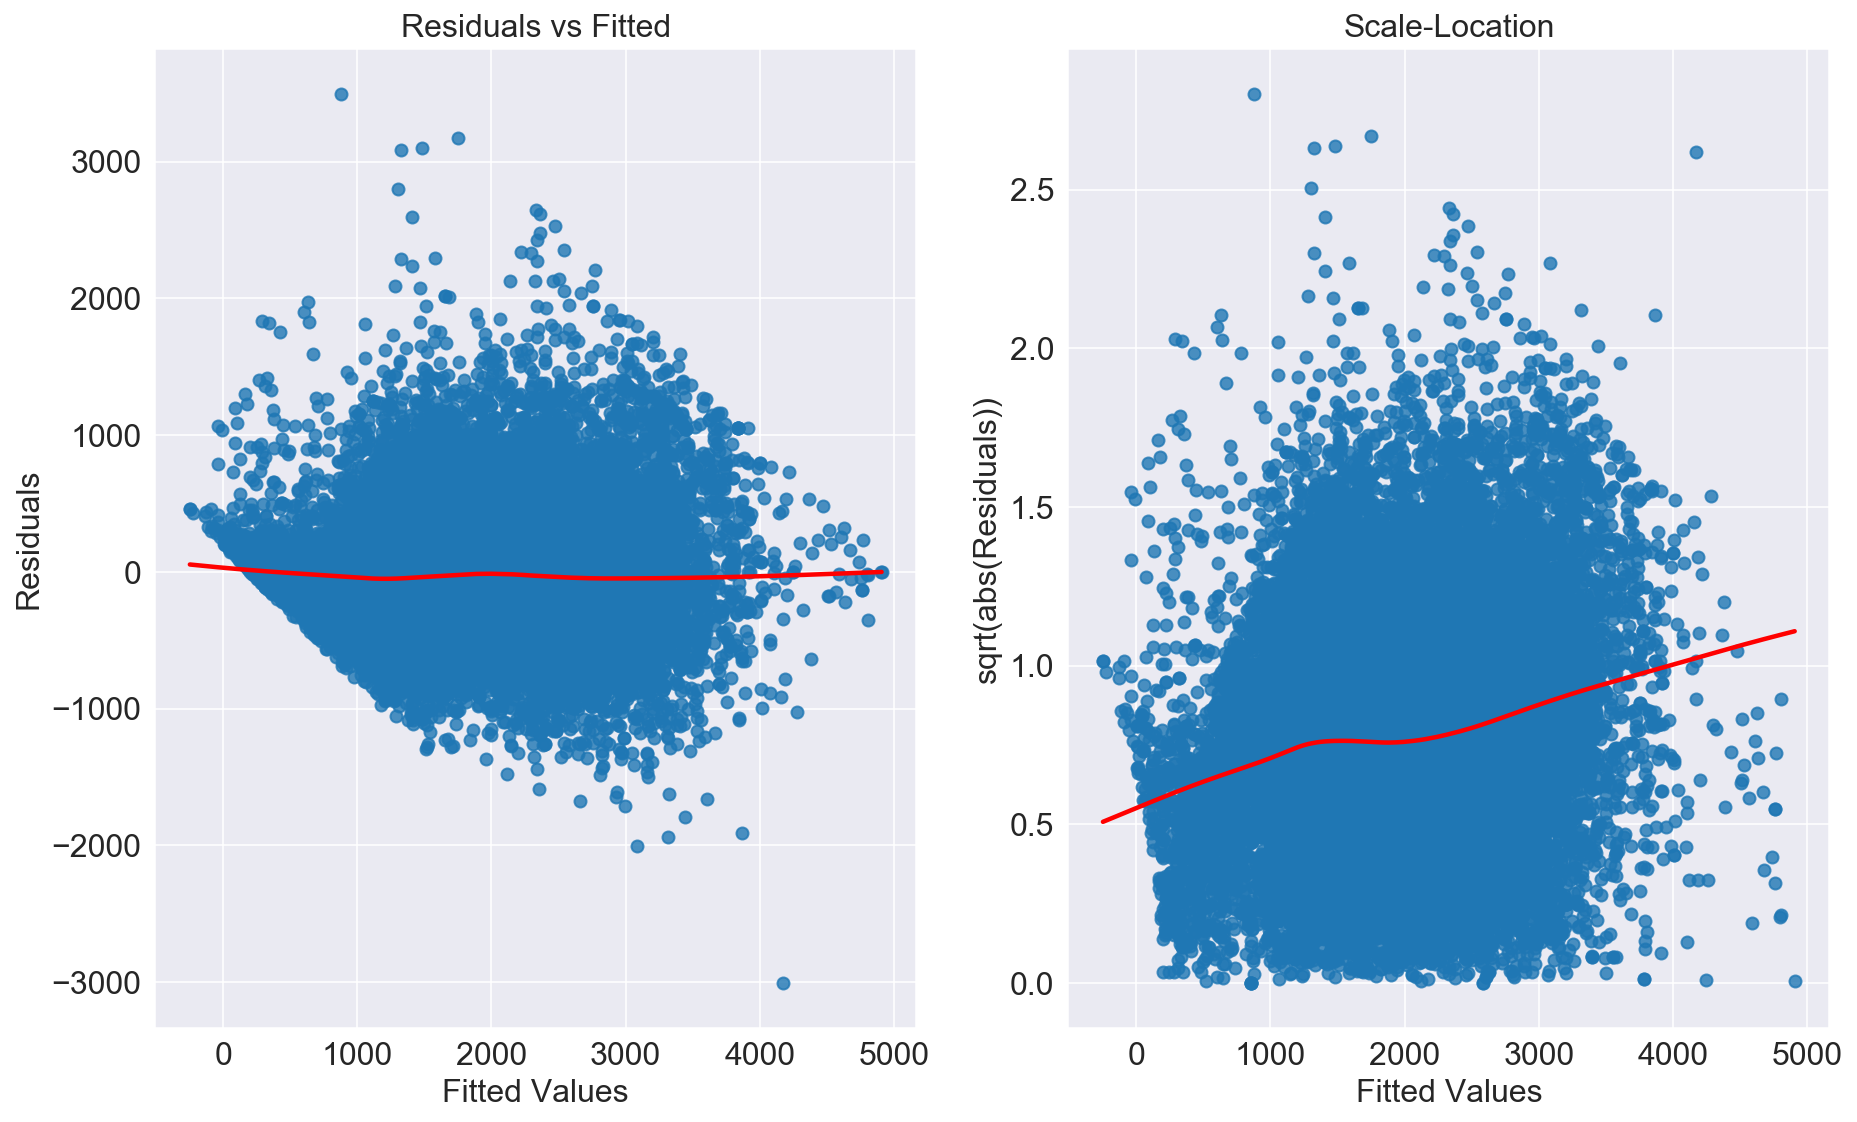

In [142]:
print ("Homocedasticidad (varianza igual) de residuos")
homoscedasticity_test(model)

#### También probemos RIDGE_CV y LASSO_CV CON con "X4_cuad_relac"

#### armammos "X4_cuad_relac"

In [143]:
X4_cuad_relac = X4_cuad_relac_const.drop(["const"], axis=1)

In [144]:
X4_cuad_relac.head(3)

surface_total_in_m2  surface_covered_in_m2  garage  balcon  patio  amenities  estrenar  gimnasio  baulera  piscina_house  ...  1219  1220  1221  1222  1223  1224  1225  1226  1227  1228
0                   55                     40       0       0      1          0         0         0        0              0  ...     0     0     0     0     0     0     0     0     0     0
2                   55                     55       0       0      0          0         0         0        0              0  ...     0     0     0     0     0     0     0     0     0     0
7                   45                     40       0       0      0          0         1         0        0              0  ...     0     0     0     0     0     0     0     0     0     0

[3 rows x 1864 columns]

#### probamos con "X4_cuad_relac"

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac, y)

#### 9-d) Lasso Regression CV (Cross Validation)

In [146]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.6979705 , 0.69976956, 0.7045418 ]), 'mean_score': 0.7007606220829253, 'zero_coefs': 1596}


In [147]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7081026806410546

#### 9-e) Ridge Regression CV (Cross Validation)

##### Ridge CV (Cross Validation)

In [148]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.70664629, 0.69602461, 0.69352044]), 'mean_score': 0.6987304461814645}


In [149]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.709372270723205

<hr id="ToCSV">
<h2 style="color: lightblue">CONCLUSIONES</h2>